# Imports

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import ptitprince as pt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from Bio import AlignIO
import warnings
import mdtraj as md
from pylab import *
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import roc_curve, auc
from scipy.stats import bootstrap
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import biotite.structure as struc
from scipy.stats import sem
from matplotlib.offsetbox import AnchoredText



warnings.filterwarnings('ignore')

# Functions

In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [3]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [4]:
def load_rosetta(data,wt_seq,gap):
    df=pd.read_excel("data/additional_file_2.xlsx",sheet_name=data)
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,1])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    count=1
    for i in range(len(wt_seq)):
            if wt_seq[i]!='-':
                for j in range(len(mutation_load)):
                    if int(mutation_load[j][1:len(mutation_load[j])-1])==count and mutation_load[j][len(mutation_load[j])-1]!= '=':
                        scores[i, alphabetAA_L_D[mutation_load[j][len(mutation_load[j])-1]]-1]= float(score_load[j])
            count+=1
    return scores

In [5]:
def load_data(data,wt_seq,start_gap=0):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,1])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=':
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

In [6]:
def heatmap_scores_reordered4(ext_score,label_cm,WT_mask,lim_down,lim_up,color,x,WT_cmap='gnuplot_r',nan_cmap='Dark2_r',figs=[30,9],xtick_spacing=50):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20

    score=np.copy(ext_score)

    for i in range(score.shape[1]):
        #print(i,score[:,i][0:10])
        score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
        #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

    score_nan=np.copy(ext_score)
    score_nan[:]=np.inf
    
    for i in range(score.shape[0]):
        for j in range(score.shape[1]):
                if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:
                    
                    score_nan[i,alphabetAA_D_D_reordered[j]]=1
                    #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])
            
    fig, ax = plt.subplots(figsize=(figs[0],figs[1]))
    ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
 
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                 vmin=lim_down,vmax=lim_up,interpolation='nearest')
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    
    #xlabels = [1] + np.arange(10,len(GCK_WT_sequence)-1,10).tolist()
    #ax.xaxis.set_ticks(np.arange(1, len(GCK_WT_sequence)-1, 10))
    #ax.set_xticklabels(xlabels)
    
    x_labels= ['1','50', '100', '150','200','250', '300', '350',  '400', '450']

    ax.set_xticks([0, 49, 99, 149, 199, 249, 299, 349, 399, 449])
    ax.set_xticklabels(x_labels)


    plt.grid(axis='both',which='both',alpha=0.4)
    #plt.ylabel("mutation")
    plt.xlabel("Position")
    plt.ylim(-0.5,19.5)
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    #ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1
    
    print(score_nan[0,:])
    plt.imshow(score_nan.T, cmap=nan_cmap, aspect = 'auto',interpolation='nearest')
    plt.imshow(tmp.T, cmap=WT_cmap, aspect = 'auto',interpolation='nearest')
    

In [7]:
def print_chimera_x_attribute_file(attribute_check,attribute,file,model_id='#1',chain_id='/A',argument='cbyvalue'):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s%s\n%s\n%s\n' % ( 'attribute: ',argument,'match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True or attribute_check[i]==-99999:
            pass
        else:
            file.write("\t%s%s%s%d\t%f\n" % (str(model_id),str(chain_id),':',i+1,attribute[i]))
    file.close()

In [8]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*', "=":"=", "Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_L_D_reordered={0:'R',1:'H',2:'K',3:'D',4:'E',5:'S',6:'T',7:'N',8:'Q',9:'C',10:'G',11:'P',12:'A',13:'V',14:'I',15:'L',16:'M',17:'F',18:'Y',19:'W'}
alphabetAA_D_D_reordered={14:0,6:1,8:2,2:3,3:4,15:5,16:6,11:7,13:8,1:9,5:10,12:11,0:12,17:13,7:14,9:15,10:16,4:17,19:18,18:19}

In [9]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):                   
    #plot the distribution of the input data (can be a vector or matrix)
    #three different normalization option: off, density (matplotlib standard normalization), True: Frobenius-norm based 
    # thr: threshold for count the variants under a custom threshold
    
    mpl.rcParams['figure.figsize']=(9,7)    
    mpl.rcParams['axes.axisbelow'] = True
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_under=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_under+=counts[i]
    print('over threshold variants:',np.sum(counts)-sum_under, ' (', (np.sum(counts)-sum_under)/np.sum(counts)*100 ,'%)')
    

In [10]:
def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)

In [11]:
GCK_WT_sequence="MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ"
GCK_WT_ros_seq1='--------------MVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRH-----------------------NVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKAC----'
GCK_WT_ros_seq2='-------------TLVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKAC----'

In [12]:
df_mave= pd.read_excel("data/additional_file_2.xlsx",sheet_name="abundance_scores")

mutation_load=np.array(df_mave.iloc[:,0])
score_load=np.array(df_mave.iloc[:,1])
errors_load=np.array(df_mave.iloc[:,2])

GCK_scores=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_scores[:]=np.nan

GCK_errors=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_errors[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][-3:] != 'Ter' :
        GCK_scores[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(score_load[i])
        GCK_errors[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(errors_load[i])

In [13]:
GCK_scores_med=np.nanmedian(GCK_scores,axis=1)

In [14]:
GCK_scores_inactivating=np.copy(GCK_scores)

for i in range(GCK_scores.shape[0]):
    for j in range(GCK_scores.shape[1]):
        
        if GCK_scores[i,j] >1.1:
            GCK_scores_inactivating[i,j]=np.nan

In [15]:
GCK_scores_inactivating_med=np.nanmedian(GCK_scores_inactivating,axis=1)

In [16]:
GCK_synonymous_mutations=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_synonymous_mutations[:]=np.nan

GCK_stop_mutations=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_stop_mutations[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]=='=':
        GCK_synonymous_mutations[int(mutation_load[i][5:len(mutation_load[i])-1])-1, 0]= float(score_load[i])
        
    elif mutation_load[i][-3:] == 'Ter' :
        GCK_stop_mutations[int(mutation_load[i][5:len(mutation_load[i])-3])-1, 0]= float(score_load[i])

In [17]:
sp.nanstd(GCK_synonymous_mutations.flatten())

0.17802669479691535

In [18]:
df_mave_activity= pd.read_excel("data/additional_file_2.xlsx",sheet_name="activity_scores")


mutation_load_act=np.array(df_mave_activity.iloc[:,0])
score_load_act=np.array(df_mave_activity.iloc[:,1])
errors_load_act=np.array(df_mave_activity.iloc[:,4])

GCK_scores_act=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_scores_act[:]=np.nan

GCK_errors_act=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_errors_act[:]=np.nan

for i in range(len(mutation_load_act)):
    if  mutation_load_act[i][len(mutation_load_act[i])-1]!= '=' and mutation_load_act[i][-3:] != 'Ter' :
        GCK_scores_act[int(mutation_load_act[i][5:len(mutation_load_act[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_act[i][-3:]]]-1]= float(score_load_act[i])
        GCK_errors_act[int(mutation_load_act[i][5:len(mutation_load_act[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_act[i][-3:]]]-1]= float(errors_load_act[i])

In [19]:
GCK_scores_med_act=np.nanmedian(GCK_scores_act,axis=1)

In [20]:
def correlation_plot(x,y,x_label='score1',y_label='score2',nan_value=-99999):
    
    def func(x, a, b):
        return a * x + b
    
    rng = np.random.default_rng()
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))    
    
    bad = ~np.logical_or(np.isnan(x), np.isnan(y)) 
    
    x_t=np.compress(bad, x)
    y_t=np.compress(bad, y)

    xy= np.vstack([x_t,y_t])
    z = sp.stats.gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    
    ax.grid(alpha=0.3)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    x_s, y_s, z = x_t[idx], y_t[idx], z[idx]
    ax.scatter(x_s, y_s, c=z, s=100,cmap='viridis')
        
    #stats

    
    print("pearson's r:", pearson_output(x_s,y_s))
    
    #correlation line

    
    optimizedParameters, pcov = curve_fit(func, x_s, y_s);
    
    ax.plot(x_s,func(x_s, *optimizedParameters),'r' ,label="fit" )
    
    ## bootstrap statistic
    
    res = bootstrap((x_s, y_s), pearson_output, vectorized=False, paired=True,
                random_state=rng)
    
    print("boostraping confidence interval:", res.confidence_interval)
    

In [21]:
def pearson_output(x,y):
    return sp.stats.pearsonr(x,y)[0]

In [22]:
def spearman_output(x,y):
    return sp.stats.spearmanr(x,y)[0]

In [23]:
def ddg_map_to_range(x):
    """
    Map ddg data to be in range
    from -1 to 7.
    """
    if x > 7:
        x = 7
        
    elif x < -1:
        x = -1
        
    else:
        x = x 
        
    return x

ddg_map_to_range = np.vectorize(ddg_map_to_range) # vectorise function

def get_resi_arr(ddg_df):
    """
    Given ddg dataframe, return array with
    residue numbers for all rows in dataframe.
    """
    variant_arr = ddg_df.variant.values
    resi = np.array([int(variant[1:-1]) for variant in variant_arr])
    
    return resi

def get_aa_var_arr(ddg_df):
    """
    Given ddg dataframe, return array with
    variant residue types for all rows in dataframe.
    """
    variant_arr = ddg_df.variant.values
    aa_var = np.array([variant[-1] for variant in variant_arr])
    
    return aa_var 

def plot_ddg_corr(ddg_arr_1,ddg_arr_2,ms):
    """
    Plot ddg_arr_1 vs ddg_arr_2. 
    Calculate Pearson R and add to plot. 
    """
    # calculate pearson correlation 
    pearson = str(np.around(sp.stats.pearsonr(ddg_arr_1,ddg_arr_2)[0],2))

    # plot
    plt.rcParams['font.size'] = '16'
    plt.figure(figsize=(5,5))
    plt.errorbar(x=ddg_arr_1,y=ddg_arr_2,
                     marker='o',ms=ms,linewidth=0,color="steelblue",
                     markeredgecolor="black",markeredgewidth=0.25)
    plt.plot(np.arange(-1,7,0.01),np.arange(-1,7,0.01),color="grey",alpha=0.5)
    plt.xlabel(r"$\Delta\Delta$G in glucose-free"+"\n"+"structure (kcal/mol)")
    plt.ylabel(r"$\Delta\Delta$G in glucose-bound"+"\n"+"structure (kcal/mol)")
    plt.xticks(ticks=[0,2,4,6],labels=[0,2,4,6])
    plt.yticks(ticks=[0,2,4,6],labels=[0,2,4,6])
    plt.annotate(fr'$r$ = {pearson}', xy=(0.7,0.07),xycoords='axes fraction', fontsize=17) 
    plt.tight_layout()
    plt.show()

def hexbin_scatter(x_arr, y_arr, x_label, y_label):
    """
    Plot hexbin of x_arr and y_arr data and 
    add Spearman R to plot.
    """
    spearman = sp.stats.spearmanr(x_arr, y_arr)[0]
    spearman = str(np.around(spearman,2))

    plt.hexbin(x_arr, y_arr, mincnt=1, cmap=sns.color_palette("crest", as_cmap=True),
               gridsize=(100), bins='log', vmin=1, vmax=75)

    # 100 gridsize for variant-level plots, 75 for residue-level plots
    # vmax 75 for variant-level plots, 5 for residue level plots

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.annotate(fr'$r_s$ = {spearman}', xy=(0.05,0.9),xycoords='axes fraction', fontsize=19) 
    
    
def scatter_per_domain(df, domain_df_dict, exp_score, figname_suffix):
    """
    Plot abundance or activity data against GEMME
    and ddG data for all variants/residues using
    data in df and for variants/residues only within
    given domain using data in domain_df_dict.
    """
    # set global figure parameters
    plt.rcParams['font.size'] = '19'
    plt.figure(figsize=(16,15))
    i = 0

    # set label names
    label_dict = {'abundance_score':'Abundance score','activity_score':'Activity score',
                  'gemme_score':'GEMME score','ddG_1v4s':r'$\Delta\Delta G$ (kcal/mol)',
                  'ddG_1v4t_avg_model_comb':r'$\Delta\Delta G$ (kcal/mol)'}

    for comp_score in ['gemme_score','ddG_1v4s','ddG_1v4t_avg_model_comb']:

        i += 1
        ax = plt.subplot(3,3,i)

        df_subset = df.dropna(subset=[comp_score,exp_score])
        x_subset = df_subset[comp_score]
        y_subset = df_subset[exp_score]
        hexbin_scatter(x_subset, y_subset, label_dict[comp_score], label_dict[exp_score])

    for comp_score in ['gemme_score','ddG_1v4s','ddG_1v4t_avg_model_comb']:

        i += 1
        ax = plt.subplot(3,3,i)

        df_subset = domain_df_dict['large_domain'].dropna(subset=[comp_score,exp_score])
        x_subset = df_subset[comp_score]
        y_subset = df_subset[exp_score]
        hexbin_scatter(x_subset, y_subset, label_dict[comp_score], label_dict[exp_score])   

    for comp_score in ['gemme_score','ddG_1v4s','ddG_1v4t_avg_model_comb']:

        i += 1
        ax = plt.subplot(3,3,i)

        df_subset = domain_df_dict['small_domain'].dropna(subset=[comp_score,exp_score])
        x_subset = df_subset[comp_score]
        y_subset = df_subset[exp_score]
        hexbin_scatter(x_subset, y_subset, label_dict[comp_score], label_dict[exp_score])   

    plt.tight_layout()

# Define domains

In [24]:
# define which residues belong to each domain in GCK
ld_res_arr = np.concatenate((np.arange(1,63+1), np.arange(204,442+1)))
sd_loop_res_arr = np.concatenate((np.arange(73,203+1),np.arange(443,465+1))) 
domain_resi_dict = {"large_domain":ld_res_arr, "small_domain":sd_loop_res_arr}

# Loading data

## Loading activity and abundance scores

In [25]:
abundance = pd.read_excel("data/additional_file_2.xlsx",sheet_name="abundance_scores")
activity = pd.read_excel("data/additional_file_2.xlsx",sheet_name="activity_scores")


In [26]:
# Abundance and activity data with hgvs_pro column split

abundance_data = abundance
abundance_data[['p', 'aa']] = abundance_data.hgvs_pro.str.split('.' ,expand=True)
abundance_data[['aa_ref_3', 'aa_var_3']] = abundance_data.aa.str.split('\d+',expand=True)
abundance_data[['residue_number']] = abundance_data['hgvs_pro'].str.extract('(\d+)').astype(int)
del abundance_data['aa']
del abundance_data['p']
abundance_data['aa_var'] = abundance_data['aa_var_3'].map(alphabetAA_3L_1L)
abundance_data['aa_ref'] = abundance_data['aa_ref_3'].map(alphabetAA_3L_1L)
abundance_data['variant'] = abundance_data['aa_ref'] + abundance_data['residue_number'].map(str) + abundance_data['aa_var']


activity_data = activity
activity_data[['p', 'aa']] = activity_data.hgvs_pro.str.split('.' ,expand=True)
activity_data[['aa_ref_3', 'aa_var_3']] = activity_data.aa.str.split('\d+',expand=True)
activity_data[['residue_number']] = activity_data['hgvs_pro'].str.extract('(\d+)').astype(int)
del activity_data['aa']
del activity_data['p']
activity_data['aa_var'] = activity_data['aa_var_3'].map(alphabetAA_3L_1L)
activity_data['aa_ref'] = activity_data['aa_ref_3'].map(alphabetAA_3L_1L)
activity_data['variant'] = activity_data['aa_ref'] + abundance_data['residue_number'].map(str) + abundance_data['aa_var']


In [27]:
scores = pd.merge(abundance, activity, how='outer', on='hgvs_pro')


In [28]:
scores_single_aa = scores
scores_single_aa[['p', 'aa']] = scores_single_aa.hgvs_pro.str.split('.' ,expand=True)
scores_single_aa[['wt_aa', 'variant_aa']] = scores_single_aa.aa.str.split('\d+',expand=True)
scores_single_aa[['position']] = scores_single_aa['hgvs_pro'].str.extract('(\d+)').astype(int)
del scores_single_aa['aa']
del scores_single_aa['p']


scores_single_aa['variant_aa_single'] = scores_single_aa['variant_aa'].map(alphabetAA_3L_1L)
scores_single_aa['wt_aa_single'] = scores_single_aa['wt_aa'].map(alphabetAA_3L_1L)


scores_single_aa['variant'] = scores_single_aa['wt_aa_single'] + scores_single_aa['position'].map(str) + scores_single_aa['variant_aa_single']


In [29]:
# Merge abundance and activity scores while retaining only variants with both scores
scores_inner = pd.merge(abundance, activity, how='inner', on='hgvs_pro')

## Loading median scores

In [30]:
med_abundance = pd.read_excel("data/additional_file_2.xlsx",sheet_name="GCK_abundance_median_df")
med_activity = pd.read_excel("data/additional_file_2.xlsx",sheet_name="GCK_activity_median_df")
med_scores = pd.merge(med_abundance, med_activity, how='outer', on='Position')

## Loading stability predictions

In [31]:
# load rosetta scores for 1v4s and 1v4t and remove rows where there is no ddG (for super-open including 157-179 predicted using models)
rosetta_1v4s = pd.read_excel("data/additional_file_2.xlsx",sheet_name="ddG_1V4S")
rosetta_1v4s['ddG_1v4s'].replace('', np.nan, inplace=True)
rosetta_1v4s.dropna(subset=['ddG_1v4s'], inplace=True)

rosetta_1v4t = pd.read_excel("data/additional_file_2.xlsx",sheet_name="ddG_1V4T_157-179_modeller")
rosetta_1v4t['ddG_1v4t'].replace('', np.nan, inplace=True)
rosetta_1v4t.dropna(subset=['ddG_1v4t'], inplace=True)

In [32]:
rosetta_GCK_1v4s_ddg=load_rosetta("ddG_1V4S",GCK_WT_ros_seq2,0)
rosetta_GCK_1v4s_ddg=remove_WT_score(rosetta_GCK_1v4s_ddg,GCK_WT_sequence)

In [33]:
rosetta_GCK_1v4s_ddg_avg=np.nanmedian(rosetta_GCK_1v4s_ddg,axis=1)

In [34]:
rosetta_GCK_1v4t_ddg=load_rosetta("ddG_1V4T_157-179_modeller",GCK_WT_ros_seq2,0)
rosetta_GCK_1v4t_ddg=remove_WT_score(rosetta_GCK_1v4t_ddg,GCK_WT_sequence)

In [35]:
rosetta_GCK_1v4t_ddg_avg=np.nanmedian(rosetta_GCK_1v4t_ddg,axis=1)

In [36]:
rosetta_diff_ddg=rosetta_GCK_1v4t_ddg-rosetta_GCK_1v4s_ddg

In [37]:
rosetta_diff_ddg=rosetta_GCK_1v4t_ddg-rosetta_GCK_1v4s_ddg
rosetta_diff_ddg_med=np.nanmedian(rosetta_diff_ddg,axis=1)

## Loading clinical data - GCK-MODY

In [38]:
df_clin= pd.read_excel("data/additional_file_2.xlsx",sheet_name="MODY")

mutation_load=np.array(df_clin.iloc[:0])
score_load=np.array(df_clin.iloc[:1])


GCK_disease=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_disease[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][-3:] != 'Ter' :
        if score_load[i]=='MODY':
            GCK_disease[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= 1
        #elif score_load[i]=='HH':
            #GCK_disease[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= 2

In [39]:
pathogenic_df = pd.merge(df_clin,abundance, how='inner', on='hgvs_pro')

In [40]:
scores_inner_mody = pd.merge(scores_inner, df_clin, how='inner', on='hgvs_pro')

In [41]:
scores_inner_mody = scores_inner_mody.loc[scores_inner_mody.disease == "MODY"]

## Loading test variants

In [42]:
test_variants = pd.read_excel("data/additional_file_2.xlsx",sheet_name="test_variants")

test_variants = pd.merge(test_variants, scores, how='left', on='hgvs_pro')

## Loading western blot data

In [43]:
wb = pd.read_excel("data/additional_file_2.xlsx",sheet_name="WB_quantification")
wb = pd.merge(wb, scores, how='inner', on='hgvs_pro')

## Loading data on weighted contact number

In [44]:
wcn_1v4s = pd.read_excel("data/additional_file_2.xlsx",sheet_name="WCN_1V4S")
wcn_1v4t = pd.read_excel("data/additional_file_2.xlsx",sheet_name="WCN_1V4T")

## Loading domain data

In [45]:
gck_domains =  pd.read_excel("data/additional_file_2.xlsx",sheet_name="domains")

# Plots and calculations

## Median activity and abundance scores

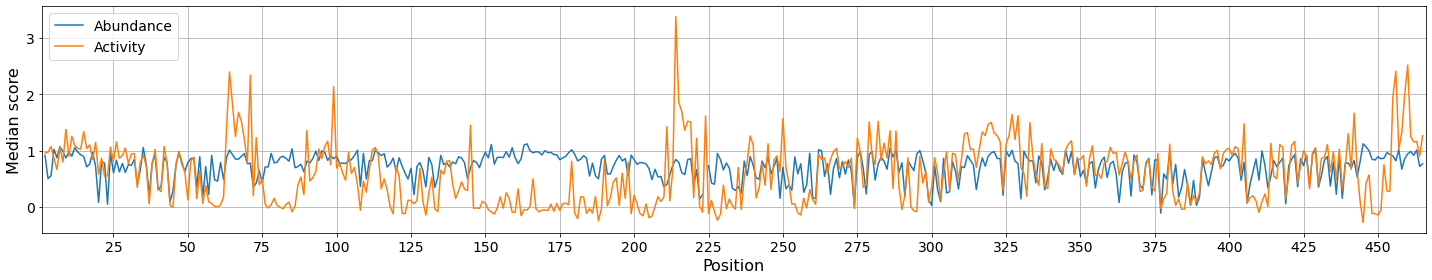

In [46]:
fig, axs = plt.subplots(figsize=(20, 4))

axs.plot('Position', 'Med_score_abundance', data=med_scores, label='Abundance')
axs.plot('Position', 'Med_score_activity', data=med_scores, label='Activity')
axs.set_xlabel('Position')
axs.set_ylabel('Median score')
axs.grid(True)
axs.set_xlim(1, 466)
axs.set_yticks([0, 1, 2, 3])
axs.set_xticks([25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450])
#axs.set_ylim(-0.2,2)

axs.legend(fontsize=14,loc='upper left')

fig.tight_layout()
plt.savefig('output-manuscript/median_abu_act_lineplot.png',dpi=600, facecolor='w')


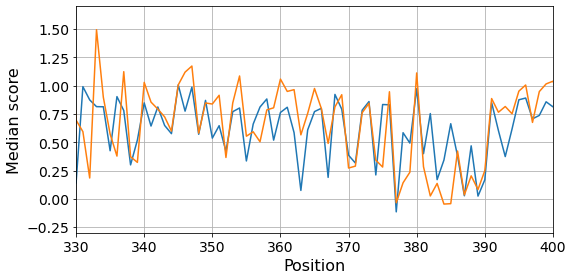

In [47]:
fig, axs = plt.subplots(figsize=(7.778, 4))

axs.plot('Position', 'Med_score_abundance', data=med_scores, label='Abundance')
axs.plot('Position', 'Med_score_activity', data=med_scores, label='Activity')
axs.set_xlabel('Position')
axs.set_ylabel('Median score')
axs.grid(True)
axs.set_xlim(330, 400)
axs.set_ylim(-0.3, 1.7)

#axs.set_yticks([0, 1, 2])
#axs.set_xticks([300, 325, 350, 375, 400])
#axs.set_ylim(-0.2,2)

#axs.legend(fontsize=14,loc='upper left')

fig.tight_layout()
plt.savefig('output-manuscript/median_abu_act_lineplot_330-400.png',dpi=600, facecolor='w')


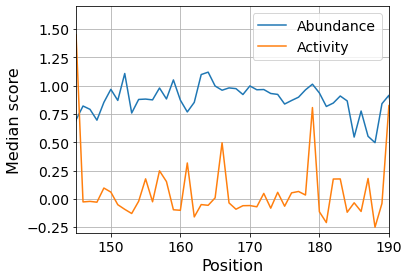

In [48]:
fig, axs = plt.subplots(figsize=(5.5, 4))

axs.plot('Position', 'Med_score_abundance', data=med_scores, label='Abundance')
axs.plot('Position', 'Med_score_activity', data=med_scores, label='Activity')
axs.set_xlabel('Position')
axs.set_ylabel('Median score')
axs.grid(True)
axs.set_xlim(145, 190)
axs.set_ylim(-0.3, 1.7)

#axs.set_yticks([0, 1, 2])
#axs.set_xticks([300, 325, 350, 375, 400])
#axs.set_ylim(-0.2,2)

axs.legend(fontsize=14,loc='upper right')

fig.tight_layout()
plt.savefig('output-manuscript/median_abu_act_lineplot_145-190.png',dpi=600, facecolor='w')

## Heatmap

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


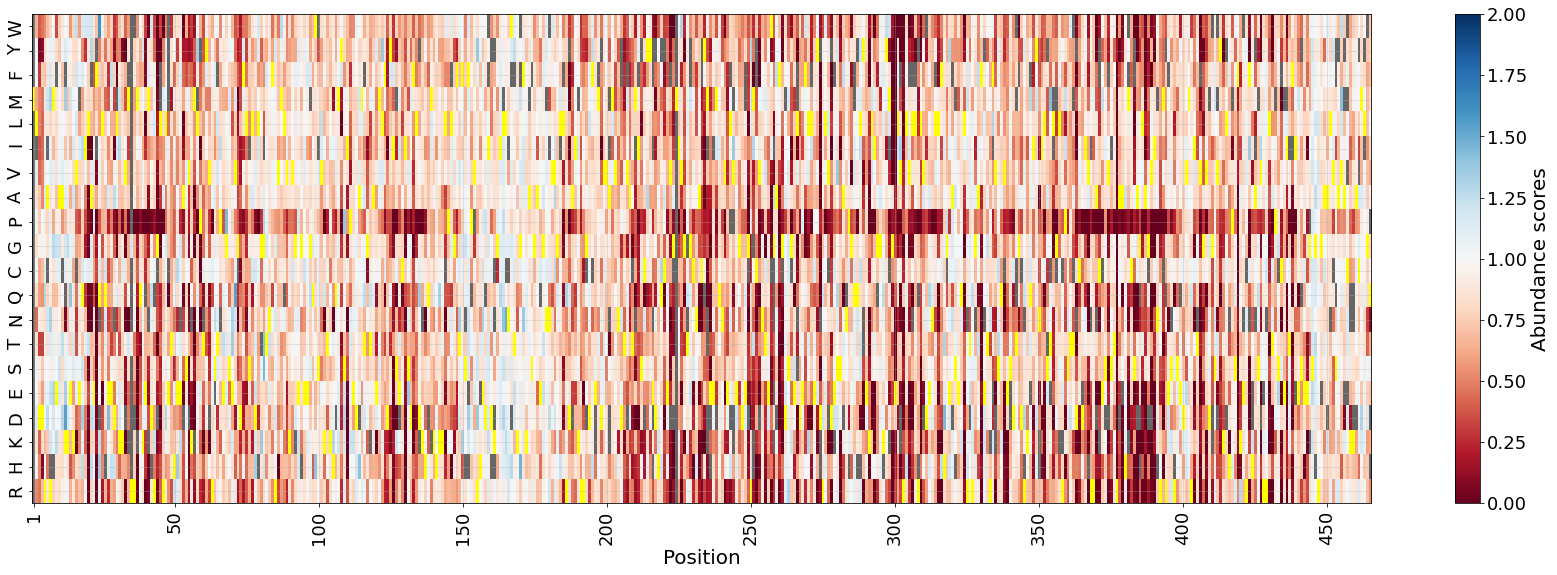

In [49]:
heatmap_scores_reordered4(GCK_scores,'Abundance scores',GCK_WT_sequence,2,0,'RdBu',[0, len(GCK_WT_sequence)-1])
plt.savefig('output-manuscript/GCK_abundance_map_full.pdf',dpi=600, facecolor='w')

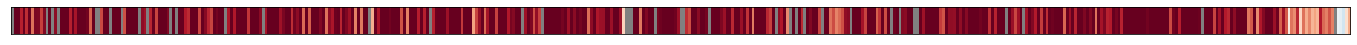

In [50]:
# Nonsense variants
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

cmap = plt.get_cmap('RdBu')
cmap.set_bad(color = 'grey')

ax1.imshow(GCK_stop_mutations.reshape(1,-1),aspect= 'auto',cmap=cmap, vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(-0.5,len(GCK_WT_sequence)-1+0.5)

plt.savefig('output-manuscript/GCK_abundance_stop_full.pdf',dpi=600, facecolor='w')


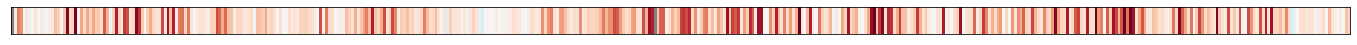

In [51]:
# Median scores
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(-0.5,len(GCK_WT_sequence)-1+0.5)

plt.savefig('output-manuscript/GCK_abundance_median_full.pdf',dpi=600, facecolor='w')

## Barcode plots

### Activity, abundance, ddG

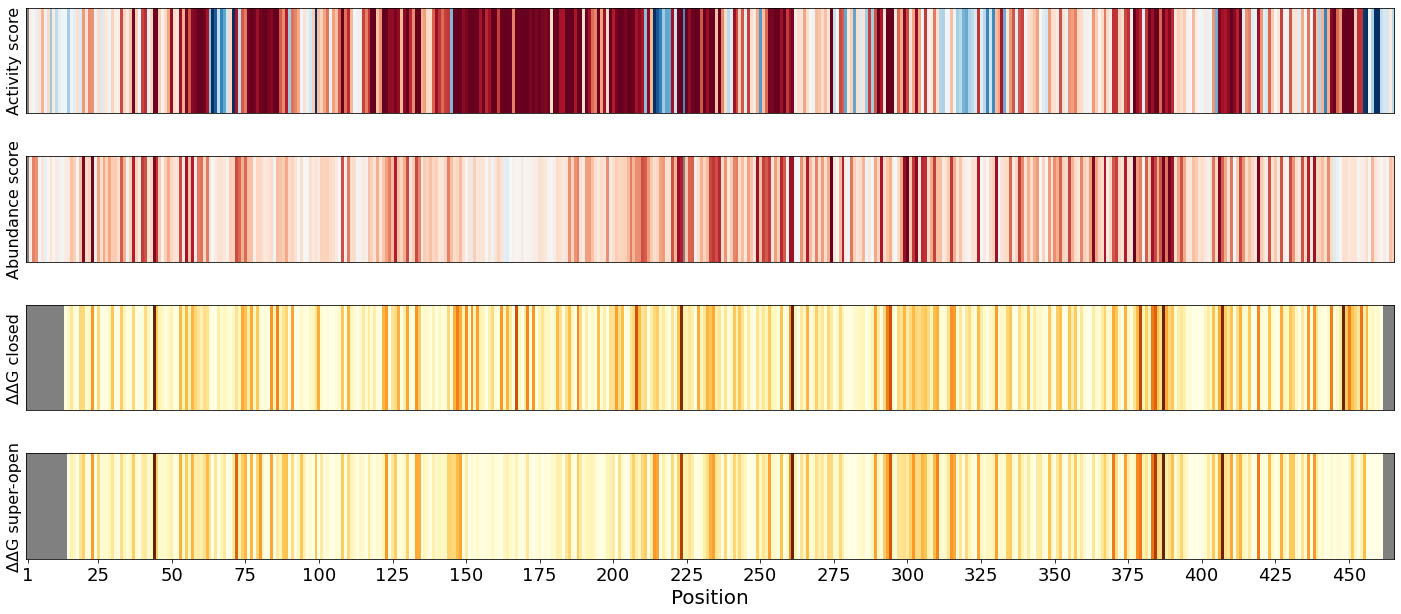

In [52]:
fig, ((ax1),(ax2),(ax3),(ax4)) = plt.subplots(4,1,figsize=(20,8.4))
plt.tight_layout()

ax1.imshow(GCK_scores_med_act.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('Activity score',fontsize=16)

ax2.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel('Abundance score',fontsize=16)


ax3.imshow(rosetta_GCK_1v4s_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=10,interpolation='nearest')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_ylabel('\u0394\u0394G closed',fontsize=16)


ax4.imshow(rosetta_GCK_1v4t_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=10,interpolation='nearest')
ax4.set_yticks([])
ax4.set_ylabel('\u0394\u0394G super-open',fontsize=16)
x_labels= ['1', '25','50','75', '100','125', '150','175','200','225','250','275', '300','325', '350','375',  '400','425', '450']
ax4.set_xticks([0,24, 49,74, 99,124, 149,174, 199,224, 249,274, 299,324, 349,374, 399,424, 449])
ax4.set_xticklabels(x_labels)
#ax4.xaxis.set_ticks(np.arange(0, len(GCK_WT_sequence), 25))

cmap = plt.get_cmap('YlOrBr')
cmap.set_bad(color = 'grey')

ax4.set_xlabel("Position")
plt.savefig('output-manuscript/GCK_barcode_act_abu_ddG.png',dpi=600, facecolor='w')

### Abundance, ddGs

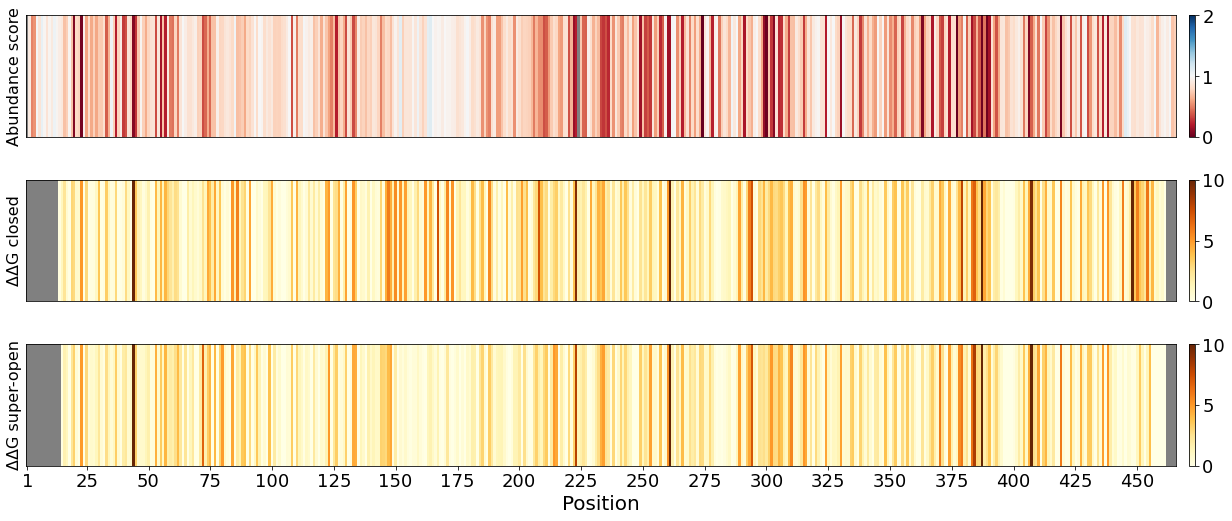

In [53]:
fig, ((ax2),(ax3),(ax4)) = plt.subplots(3,1,figsize=(20,7))
plt.tight_layout()
 
shw1 = ax2.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel('Abundance score',fontsize=16)


shw2 = ax3.imshow(rosetta_GCK_1v4s_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=10,interpolation='nearest')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_ylabel('\u0394\u0394G closed',fontsize=16)


shw3 = ax4.imshow(rosetta_GCK_1v4t_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=10,interpolation='nearest')
ax4.set_yticks([])
ax4.set_ylabel('\u0394\u0394G super-open',fontsize=16)
x_labels= ['1', '25','50','75', '100','125', '150','175','200','225','250','275', '300','325', '350','375',  '400','425', '450']
ax4.set_xticks([0,24, 49,74, 99,124, 149,174, 199,224, 249,274, 299,324, 349,374, 399,424, 449])
ax4.set_xticklabels(x_labels)
ax4.set_xlabel("Position")


cmap = plt.get_cmap('YlOrBr')
cmap.set_bad(color = 'grey')

bar1 = fig.colorbar(shw1, ax=ax2, location='right', pad=0.01)
bar2 = fig.colorbar(shw2, ax=ax3, location='right', pad=0.01)
bar3 = fig.colorbar(shw3, ax=ax4, location='right', pad=0.01)

plt.savefig('output-manuscript/GCK_barcode_abu_ddG.png',dpi=600, facecolor='w', bbox_inches='tight')

### Abundance, ddGs, dddG

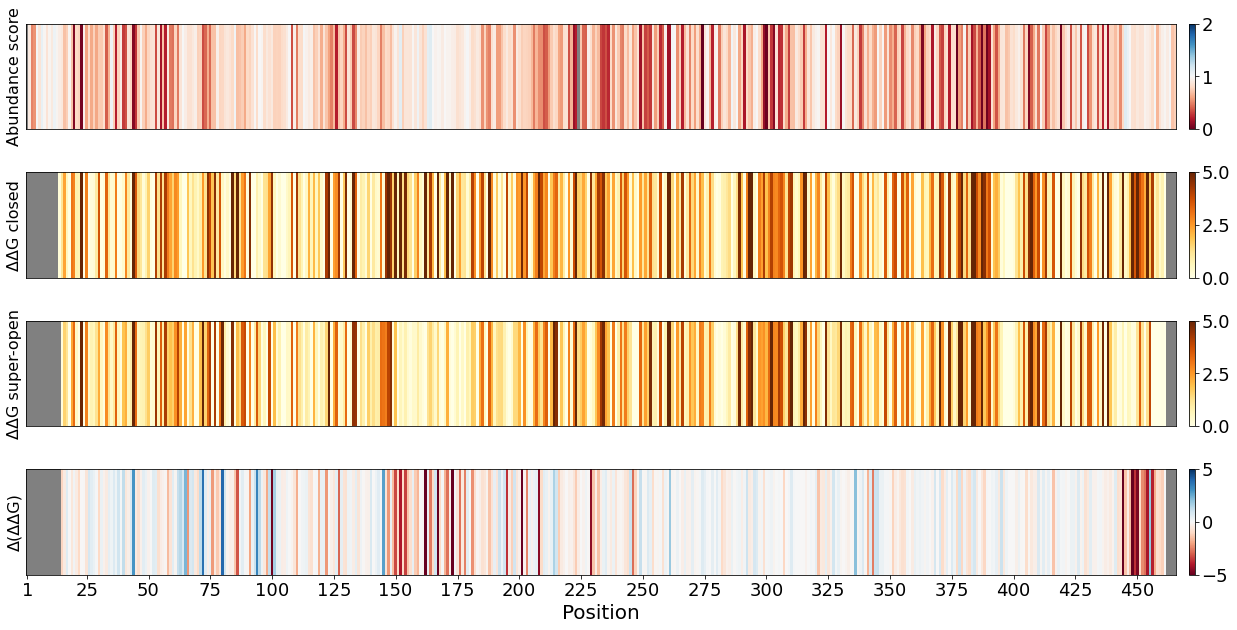

In [54]:
fig, ((ax2),(ax3),(ax4), (ax5)) = plt.subplots(4,1,figsize=(20,8.4))
plt.tight_layout()
 
    
shw1 = ax2.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel('Abundance score',fontsize=16)


shw2 = ax3.imshow(rosetta_GCK_1v4s_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_ylabel('\u0394\u0394G closed',fontsize=16)


shw3 = ax4.imshow(rosetta_GCK_1v4t_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax4.set_yticks([])
ax4.set_xticks([])
ax4.set_ylabel('\u0394\u0394G super-open',fontsize=16)


shw4 = ax5.imshow(rosetta_diff_ddg_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=-5,vmax=5,interpolation='nearest')
ax5.set_yticks([])
ax5.set_ylabel('\u0394(\u0394\u0394G)',fontsize=16)
x_labels= ['1', '25','50','75', '100','125', '150','175','200','225','250','275', '300','325', '350','375',  '400','425', '450']
ax5.set_xticks([0,24, 49,74, 99,124, 149,174, 199,224, 249,274, 299,324, 349,374, 399,424, 449])
ax5.set_xticklabels(x_labels)
ax5.set_xlabel("Position")


cmap = plt.get_cmap('YlOrBr')
cmap.set_bad(color = 'grey')

bar1 = fig.colorbar(shw1, ax=ax2, location='right', pad=0.01)
bar2 = fig.colorbar(shw2, ax=ax3, location='right', pad=0.01)
bar3 = fig.colorbar(shw3, ax=ax4, location='right', pad=0.01)
bar4 = fig.colorbar(shw4, ax=ax5, location='right', pad=0.01)

plt.savefig('output-manuscript/GCK_barcode_abu_dddG.png',dpi=600, facecolor='w', bbox_inches='tight')

### Activity, abundance, ddG, dddG

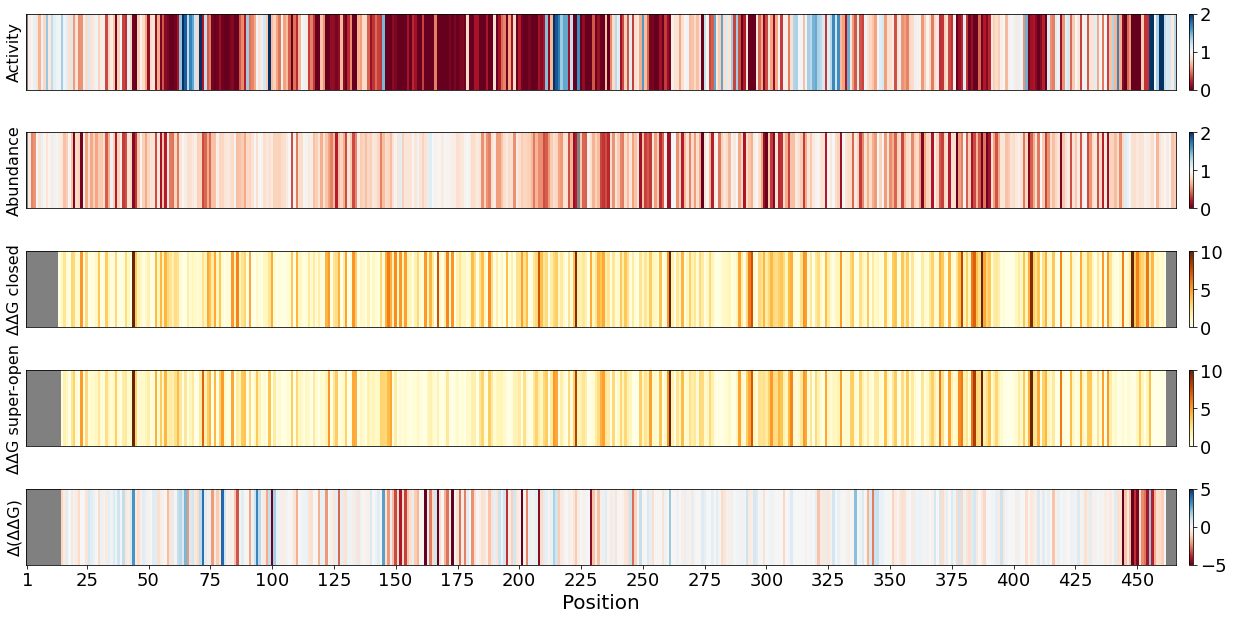

In [55]:
fig, ((ax1), (ax2),(ax3),(ax4), (ax5)) = plt.subplots(5,1,figsize=(20,8.4))
plt.tight_layout()

shw1 = ax1.imshow(GCK_scores_med_act.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('Activity',fontsize=16)


shw2 = ax2.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel('Abundance',fontsize=16)


shw3 = ax3.imshow(rosetta_GCK_1v4s_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=10,interpolation='nearest')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_ylabel('\u0394\u0394G closed',fontsize=16)


shw4 = ax4.imshow(rosetta_GCK_1v4t_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=10,interpolation='nearest')
ax4.set_yticks([])
ax4.set_xticks([])
ax4.set_ylabel('\u0394\u0394G super-open',fontsize=16)


shw5 = ax5.imshow(rosetta_diff_ddg_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=-5,vmax=5,interpolation='nearest')
ax5.set_yticks([])
ax5.set_ylabel('\u0394(\u0394\u0394G)',fontsize=16)
x_labels= ['1', '25','50','75', '100','125', '150','175','200','225','250','275', '300','325', '350','375',  '400','425', '450']
ax5.set_xticks([0,24, 49,74, 99,124, 149,174, 199,224, 249,274, 299,324, 349,374, 399,424, 449])
ax5.set_xticklabels(x_labels)
ax5.set_xlabel("Position")

cmap = plt.get_cmap('YlOrBr')
cmap.set_bad(color = 'grey')

bar1 = fig.colorbar(shw1, ax=ax1, location='right', pad=0.01)
bar2 = fig.colorbar(shw2, ax=ax2, location='right', pad=0.01)
bar3 = fig.colorbar(shw3, ax=ax3, location='right', pad=0.01)
bar4 = fig.colorbar(shw4, ax=ax4, location='right', pad=0.01)
bar5 = fig.colorbar(shw5, ax=ax5, location='right', pad=0.01)

plt.savefig('output-manuscript/GCK_barcode_act_abu_dddG.png',dpi=600, facecolor='w', bbox_inches='tight')

### Activity, abundance

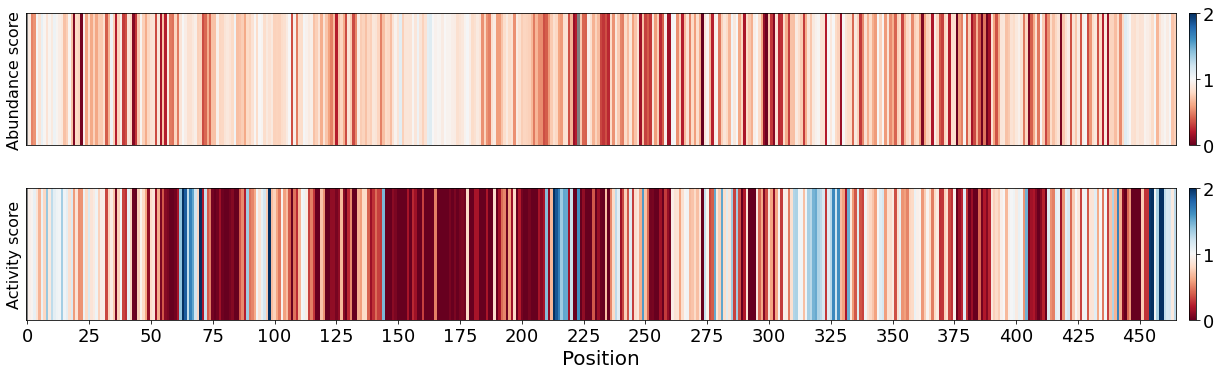

In [56]:
fig, ((ax2),(ax1)) = plt.subplots(2,1,figsize=(20,5))
plt.tight_layout()

shw1 = ax1.imshow(GCK_scores_med_act.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('Activity score',fontsize=16)

shw2 = ax2.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel('Abundance score',fontsize=16)

ax1.xaxis.set_ticks(np.arange(0, len(GCK_WT_sequence), 25))

bar1 = fig.colorbar(shw1, ax=ax1, location='right', pad=0.01)
bar2 = fig.colorbar(shw2, ax=ax2, location='right', pad=0.01)


ax1.set_xlabel("Position")
plt.savefig('output-manuscript/GCK_barcode_act_abu.png',dpi=600, facecolor='w',bbox_inches='tight')

## Abundance score distribution

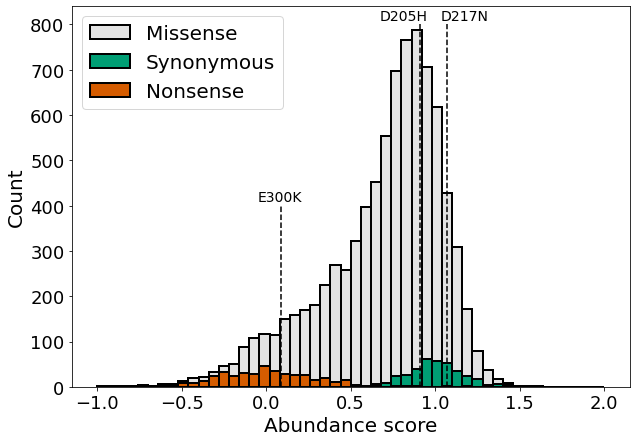

In [57]:
fig, ax = plt.subplots(figsize=(10,7))

ax.hist(GCK_scores.flatten(),bins=50, range=(-1,2),facecolor='#e3e3e3',edgecolor='k',lw=2,label='Missense')
ax.hist(GCK_synonymous_mutations
        .flatten(),bins=50,range=(-1,2),facecolor='#009E74',edgecolor='k',lw=2,label='Synonymous')
ax.hist(GCK_stop_mutations.flatten(),bins=50,range=(-1,2),facecolor='#d55c00',edgecolor='k',lw=2,label='Nonsense')

# Marking E300K
ax.vlines(x=[scores.loc[scores['hgvs_pro'] == 'p.Glu300Lys', 'score_abundance'].iloc[0]],ymax=400, ymin=0, colors='black', ls='--')
ax.text(((scores.loc[scores['hgvs_pro'] == 'p.Glu300Lys', 'score_abundance'].iloc[0])-0.14), 410, 'E300K', color='black', size=14)

# Marking D205H
ax.vlines(x=[scores.loc[scores['hgvs_pro'] == 'p.Asp205His', 'score_abundance'].iloc[0]],ymax=800, ymin=0, colors='black', ls='--')
ax.text(((scores.loc[scores['hgvs_pro'] == 'p.Asp205His', 'score_abundance'].iloc[0])-0.24), 810, 'D205H', color='black', size=14)


ax.vlines(x=[scores.loc[scores['hgvs_pro'] == 'p.Asp217Asn', 'score_abundance'].iloc[0]],ymax=800, ymin=0, colors='black', ls='--')
ax.text(((scores.loc[scores['hgvs_pro'] == 'p.Asp217Asn', 'score_abundance'].iloc[0])-0.04), 810, 'D217N', color='black', size=14)


ax.legend(fontsize=20)
ax.set_xlabel('Abundance score')
ax.set_ylabel('Count')

plt.savefig('output-manuscript/GCK_abundance_score_distribution.png',dpi=600, facecolor='w')

## 2D histogram of activity and abundance with squares (incl. missense, synonymous and nonsense)

In [58]:
#Custom color map
Wistia = mpl.cm.get_cmap('YlOrBr', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp = ListedColormap(newcolors)

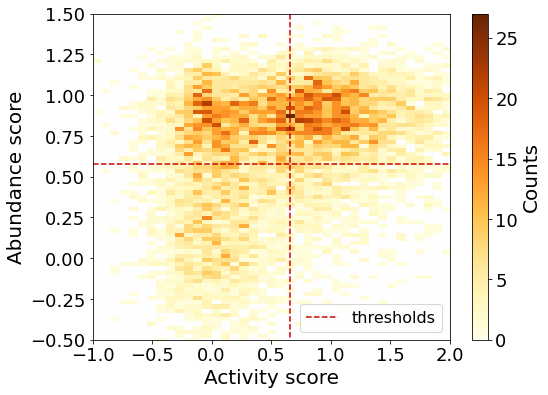

In [59]:
fig = plt.subplots(figsize = (8, 6))

plt.hist2d(scores_inner["score_activity"], scores_inner["score_abundance"], bins=100, cmap=newcmp)
cbar= plt.colorbar(label="Counts")

x_size = [-1, 2]
y_size=  [1.5, -0.5]


# Score thresholds
y_threshold=0.58 # Abundance threshold
x_threshold=0.66 # Activity threshold



horiz_line = np.array( [y_threshold for i in range(len(x_size))])
plt.plot(x_size, horiz_line, 'r--',color='#cc0000') 

vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='thresholds',color='#cc0000')

plt.xlabel("Activity score")
plt.ylabel("Abundance score")



plt.legend(loc='lower right',fontsize=16)
plt.xlim(x_size[0],x_size[1])
plt.ylim(y_size[1],y_size[0])


plt.savefig('output-manuscript/histogram_act_abu.png',dpi=600, facecolor='w', bbox_inches='tight')

### Percentages of variants in different quadrants

In [60]:
# Low activity and low abundance

(len(scores_inner.loc[(scores_inner.score_abundance < 0.58) & (scores_inner.score_activity < 0.66)]))

2126

In [61]:
(len(scores_inner.loc[(scores_inner.score_abundance < 0.58) & (scores_inner.score_activity < 0.66)])) / (len(scores_inner))

0.23572458143918396

In [62]:
# Low activity and high abundance

(len(scores_inner.loc[(scores_inner.score_abundance > 0.58) & (scores_inner.score_activity < 0.66)]))

2853

In [63]:
(len(scores_inner.loc[(scores_inner.score_abundance > 0.58) & (scores_inner.score_activity < 0.66)])) / (len(scores_inner))

0.3163321876039472

In [64]:
# High activity and low abundance

(len(scores_inner.loc[(scores_inner.score_abundance < 0.58) & (scores_inner.score_activity > 0.66)]))

727

In [65]:
(len(scores_inner.loc[(scores_inner.score_abundance < 0.58) & (scores_inner.score_activity > 0.66)])) / (len(scores_inner))

0.08060760616476327

In [66]:
# High activity and high abundance

(len(scores_inner.loc[(scores_inner.score_abundance > 0.58) & (scores_inner.score_activity > 0.66)]))

3313

In [67]:
(len(scores_inner.loc[(scores_inner.score_abundance > 0.58) & (scores_inner.score_activity > 0.66)])) / (len(scores_inner))

0.3673356247921056

In [68]:
# How many low activity variants have low abundance
# low activity
low_activity = scores_inner.loc[scores_inner.score_activity < 0.66]
len(low_activity)

4979

In [69]:
# Low abundance of low activity variants
(len(low_activity.loc[low_activity.score_abundance < 0.58]))

2126

In [70]:
(len(low_activity.loc[low_activity.score_abundance < 0.58])) / (len(low_activity))

0.42699337216308497

In [71]:
# How many low abundance variants have normal activity
# low abundance
low_abundance = scores_inner.loc[scores_inner.score_abundance < 0.58]
len(low_abundance)

2853

In [72]:
# Normal/high activity of low abundance variants
(len(low_abundance.loc[low_abundance.score_activity >= 0.66]))

727

In [73]:
(len(low_abundance.loc[low_abundance.score_activity >= 0.66])) / (len(low_abundance))

0.25481948825797407

## Loss of activity due to loss of abundance using ddG

In [74]:
# Merge assay scores with ddG
# Closed structure
scores_1v4s = pd.merge(scores_single_aa, rosetta_1v4s, how = 'inner', on = 'variant')

#Super-open structure 
scores_1v4t = pd.merge(scores_single_aa, rosetta_1v4t, how = 'inner', on = 'variant')

In [75]:
# How many low activity variants have a high ddG (>2kcal/mol) - closed structure

low_activity_2 = scores_1v4s.loc[scores_1v4s.score_activity < 0.66]

(len(low_activity_2.loc[low_activity_2.ddG_1v4s > 2])) / (len(low_activity_2))

0.5259559923093357

In [76]:
low_activity_2.to_csv('output-manuscript/low_activity_1v4s.csv', index=False)

In [77]:
# How many low activity variants have a high ddG (>2kcal/mol) - super-open structure

low_activity_3 = scores_1v4t.loc[scores_1v4t.score_activity < 0.66]

(len(low_activity_3.loc[low_activity_3.ddG_1v4t > 2])) / (len(low_activity_3))

0.42728828058169377

In [78]:
low_activity_3.to_csv('output-manuscript/low_activity_1v4t.csv', index=False)

## Plot of pathogenic variants

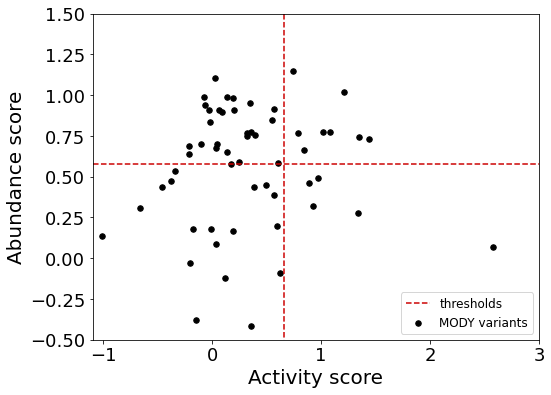

In [79]:
fig = plt.subplots(figsize = (8, 6))

x_size = [-1.1, 3]
y_size=  [1.5, -0.5]


# Score thresholds
y_threshold=0.58 # Abundance threshold
x_threshold=0.66 # Activity threshold

horiz_line = np.array( [y_threshold for i in range(len(x_size))])
plt.plot(x_size, horiz_line, 'r--',color='#cc0000') 

vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='thresholds',color='#cc0000')

plt.xlabel("Activity score")
plt.ylabel("Abundance score")

plt.scatter(x=scores_inner_mody['score_activity'], y=scores_inner_mody['score_abundance'], s=30, color='black', label='MODY variants')


plt.legend(loc='lower right',fontsize=12)
plt.xlim(x_size[0],x_size[1])
plt.ylim(y_size[1],y_size[0])

plt.savefig('output-manuscript/act_abu_mody.png',dpi=600, facecolor='w',bbox_inches='tight')

### Percentages

In [80]:
# Low activity and low abundance

(len(scores_inner_mody.loc[(scores_inner_mody.score_abundance < 0.58) & (scores_inner_mody.score_activity < 0.66)]))

18

In [81]:
(len(scores_inner_mody.loc[(scores_inner_mody.score_abundance < 0.58) & (scores_inner_mody.score_activity < 0.66)])) / (len(scores_inner_mody))

0.3157894736842105

In [82]:
# Low activity and high abundance

(len(scores_inner_mody.loc[(scores_inner_mody.score_abundance > 0.58) & (scores_inner_mody.score_activity < 0.66)]))

26

In [83]:
(len(scores_inner_mody.loc[(scores_inner_mody.score_abundance > 0.58) & (scores_inner_mody.score_activity < 0.66)])) / (len(scores_inner_mody))

0.45614035087719296

In [84]:
# High activity and low abundance

(len(scores_inner_mody.loc[(scores_inner_mody.score_abundance < 0.58) & (scores_inner_mody.score_activity > 0.66)]))

5

In [85]:
(len(scores_inner_mody.loc[(scores_inner_mody.score_abundance < 0.58) & (scores_inner_mody.score_activity > 0.66)])) / (len(scores_inner_mody))

0.08771929824561403

In [86]:
# High activity and high abundance

(len(scores_inner_mody.loc[(scores_inner_mody.score_abundance > 0.58) & (scores_inner_mody.score_activity > 0.66)]))

8

In [87]:
(len(scores_inner_mody.loc[(scores_inner_mody.score_abundance > 0.58) & (scores_inner_mody.score_activity > 0.66)])) / (len(scores_inner_mody))

0.14035087719298245

In [88]:
len(scores_inner_mody)

57

In [89]:
# How many low activity variants have low abundance
# low activity
low_activity_mody = scores_inner_mody.loc[scores_inner_mody.score_activity < 0.66]
len(low_activity_mody)

44

In [90]:
# Low abundance of low activity variants
(len(low_activity_mody.loc[low_activity_mody.score_abundance < 0.58]))

18

In [91]:
(len(low_activity_mody.loc[low_activity_mody.score_abundance < 0.58])) / (len(low_activity_mody))

0.4090909090909091

In [92]:
# Normal abundance of low activity variants
(len(low_activity_mody.loc[low_activity_mody.score_abundance > 0.58]))

26

In [93]:
(len(low_activity_mody.loc[low_activity_mody.score_abundance > 0.58])) / (len(low_activity_mody))

0.5909090909090909

In [94]:
# How many low abundance variants have normal activity
# low abundance
low_abundance_mody = scores_inner_mody.loc[scores_inner_mody.score_abundance < 0.58]
len(low_abundance_mody)

23

In [95]:
# Normal/high activity of low abundance variants
(len(low_abundance_mody.loc[low_abundance_mody.score_activity >= 0.66]))

5

In [96]:
(len(low_abundance_mody.loc[low_abundance_mody.score_activity >= 0.66])) / (len(low_abundance_mody))

0.21739130434782608

## Abundance scores of test variants

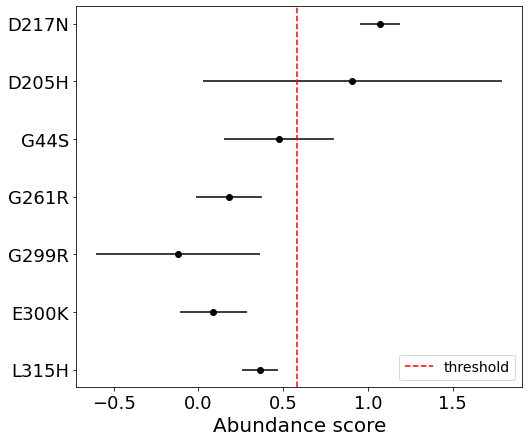

In [97]:
#reverse order so plotted in correct order
test_variants = test_variants.iloc[::-1]

test_range = range(1, len(test_variants.index)+1)


fig,ax=plt.subplots(1,1,figsize=(8,7))


ax.set_yticks(test_range)
ax.set_yticklabels(test_variants['variant'])

plt.xlabel('Abundance score')

 
# Horizontal version
plt.plot(test_variants['score_abundance'], test_range,"o", color='black')
plt.yticks(test_range, test_variants['variant'])

plt.errorbar(test_variants['score_abundance'], test_range, yerr=None, xerr= test_variants['se_x'], linestyle='none', color='black')


#threshold line
plt.axvline(0.58, ls='--', color='r', label='threshold')

plt.legend(loc='lower right',fontsize=14)



plt.savefig('output-manuscript/test_variants.png',dpi=600, facecolor='w')

## Test variants WB quantification plot

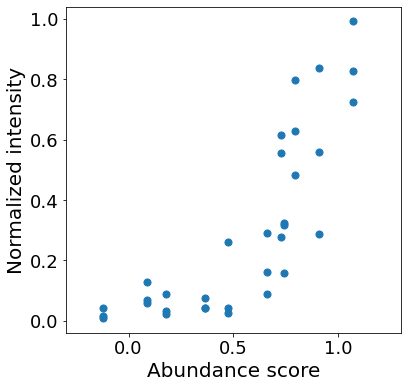

In [98]:
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(wb['score_abundance'], wb['normalized_int'],s=50)
plt.xlabel('Abundance score')
plt.ylabel('Normalized intensity')

#annotations = wb['variant'].tolist()

#for i, label in enumerate(annotations):
    #plt.annotate(label, (wb['score_abundance'][i], wb['normalized_int'][i]-0.03))

plt.xlim(-0.3, 1.3)

pearson_output(wb['score_abundance'],wb['normalized_int'])



plt.savefig('output-manuscript/variants_wb_quantification.png',dpi=600, facecolor='w', bbox_inches='tight')


In [99]:
spearman_output(wb['score_abundance'],wb['normalized_int'])


0.8705191772638439

In [100]:
pearson_output(wb['score_abundance'],wb['normalized_int'])


0.8004428415896485

In [101]:
stats.pearsonr(wb['score_abundance'],wb['normalized_int'])

(0.8004428415896485, 2.247722051089691e-08)

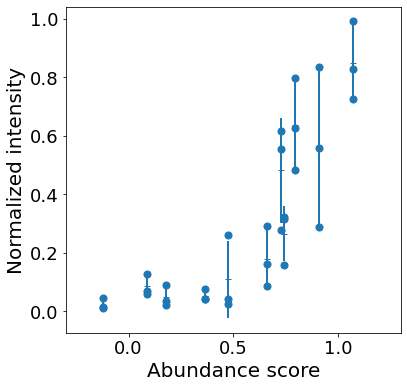

In [102]:
fig, ax = plt.subplots(figsize=(6,6))


plt.errorbar(wb['score_abundance'], wb['mean'],yerr=wb['std_dev'], fmt='_', elinewidth=2, capsize=0)


plt.scatter(wb['score_abundance'], wb['normalized_int'],s=50)
plt.xlabel('Abundance score')
plt.ylabel('Normalized intensity')


#annotations = wb['variant'].tolist()

#for i, label in enumerate(annotations):
    #plt.annotate(label, (wb['score_abundance'][i], wb['normalized_int'][i]-0.03))

plt.xlim(-0.3, 1.3)

pearson_output(wb['score_abundance'],wb['normalized_int'])



plt.savefig('output-manuscript/variants_wb_quantification_errorbars.png',dpi=600, facecolor='w', bbox_inches='tight')


## Weighted contact number

In [103]:
# Merge domain and wcn data with median abundance
gck_domains = pd.merge(gck_domains, med_abundance, how="outer", on="Position")
gck_domains_1v4s_wcn = pd.merge(gck_domains, wcn_1v4s, how="outer", left_on="Position", right_on="residue_number")
gck_domains_1v4t_wcn =pd.merge(gck_domains, wcn_1v4t, how="outer", left_on="Position", right_on="residue_number")

In [104]:
# drop NAs
gck_domains_1v4s_wcn = gck_domains_1v4s_wcn.dropna()
gck_domains_1v4t_wcn = gck_domains_1v4t_wcn.dropna()


In [105]:
# Filter for small and large domain

#1v4s
gck_domains_1v4s_wcn_small = gck_domains_1v4s_wcn.loc[gck_domains_1v4s_wcn.domain == "small"]
gck_domains_1v4s_wcn_large = gck_domains_1v4s_wcn.loc[gck_domains_1v4s_wcn.domain == "large"]

#1v4t
gck_domains_1v4t_wcn_small = gck_domains_1v4t_wcn.loc[gck_domains_1v4t_wcn.domain == "small"]
gck_domains_1v4t_wcn_large = gck_domains_1v4t_wcn.loc[gck_domains_1v4t_wcn.domain == "large"]

### Pearson's correlations

In [106]:
# Calculation Pearson's correlation - 1v4s 

pearson_output(gck_domains_1v4s_wcn['Med_score_abundance'],gck_domains_1v4s_wcn['WCN'])

-0.40479539760418676

In [107]:
# Calculation Pearson's correlation - 1v4s small domain

pearson_output(gck_domains_1v4s_wcn_small['Med_score_abundance'],gck_domains_1v4s_wcn_small['WCN'])

-0.09379533477420679

In [108]:
# Calculation Pearson's correlation - 1v4s large domain

pearson_output(gck_domains_1v4s_wcn_large['Med_score_abundance'],gck_domains_1v4s_wcn_large['WCN'])

-0.5228413608559794

In [109]:
# Calculation Pearson's correlation - 1v4t 

pearson_output(gck_domains_1v4t_wcn['Med_score_abundance'],gck_domains_1v4t_wcn['WCN'])

-0.5717267082755892

In [110]:
# Calculation Pearson's correlation - 1v4t small domain

pearson_output(gck_domains_1v4t_wcn_small['Med_score_abundance'],gck_domains_1v4t_wcn_small['WCN'])

-0.45160909884024325

In [111]:
# Calculation Pearson's correlation - 1v4t large domain

pearson_output(gck_domains_1v4t_wcn_large['Med_score_abundance'],gck_domains_1v4t_wcn_large['WCN'])

-0.5721555869129588

### Plot correlations

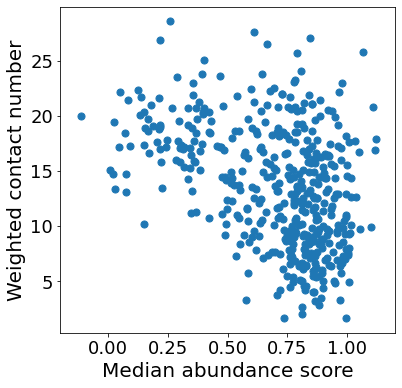

In [112]:
# 1v4s
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(gck_domains_1v4s_wcn['Med_score_abundance'],gck_domains_1v4s_wcn['WCN'],s=50)
plt.xlabel('Median abundance score')
plt.ylabel('Weighted contact number')


pearson_output(gck_domains_1v4s_wcn['Med_score_abundance'],gck_domains_1v4s_wcn['WCN'])

plt.xlim(-0.2, 1.2)


plt.savefig('output-manuscript/gck_1v4s_wcn.png',dpi=600, facecolor='w', bbox_inches='tight')


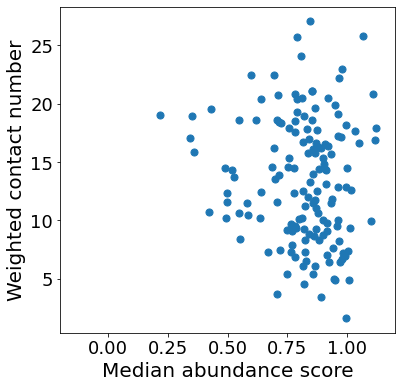

In [113]:
# 1v4s - small domain
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(gck_domains_1v4s_wcn_small['Med_score_abundance'],gck_domains_1v4s_wcn_small['WCN'],s=50)
plt.xlabel('Median abundance score')
plt.ylabel('Weighted contact number')


pearson_output(gck_domains_1v4s_wcn_small['Med_score_abundance'],gck_domains_1v4s_wcn_small['WCN'])

plt.xlim(-0.2, 1.2)


plt.savefig('output-manuscript/gck_1v4s_wcn_small_domain.png',dpi=600, facecolor='w', bbox_inches='tight')


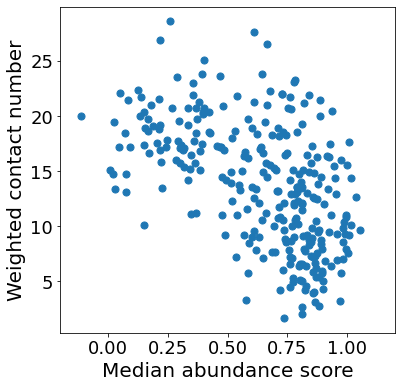

In [114]:
# 1v4s - large domain
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(gck_domains_1v4s_wcn_large['Med_score_abundance'],gck_domains_1v4s_wcn_large['WCN'],s=50)
plt.xlabel('Median abundance score')
plt.ylabel('Weighted contact number')


pearson_output(gck_domains_1v4s_wcn_large['Med_score_abundance'],gck_domains_1v4s_wcn_large['WCN'])

plt.xlim(-0.2, 1.2)

plt.savefig('output-manuscript/gck_1v4s_wcn_large_domain.png',dpi=600, facecolor='w', bbox_inches='tight')


## Number of residues with median score below threshold in the two domains

In [115]:
# Divide data into small and large domain
gck_domains_small = gck_domains.loc[gck_domains.domain == "small"]
gck_domains_large = gck_domains.loc[gck_domains.domain == "large"]


### How many residues in two domains below threshold

In [116]:
(len(gck_domains_small.loc[gck_domains_small.Med_score_abundance < 0.58])) / (len(gck_domains_small))

0.09740259740259741

In [117]:
(len(gck_domains_large.loc[gck_domains_large.Med_score_abundance < 0.58])) / (len(gck_domains_large))

0.33112582781456956

### The same as above but for activity

In [118]:
# Merge data on domains with median activity and divide dataframe into small and large domain
gck_domains_act = pd.merge(gck_domains, med_activity, how="inner", on="Position")
gck_domains_act_small = gck_domains_act.loc[gck_domains_act.domain=="small"]
gck_domains_act_large = gck_domains_act.loc[gck_domains_act.domain=="large"]

In [119]:
# How many residues in small domain have a median activity score below 0.66
(len(gck_domains_act_small.loc[gck_domains_act_small.Med_score_activity < 0.66])) / (len(gck_domains_act_small))

0.7662337662337663

In [120]:
# How many residues in large domain have a median activity score below 0.66
(len(gck_domains_act_large.loc[gck_domains_act_large.Med_score_activity < 0.66])) / (len(gck_domains_act_large))

0.4337748344370861

### Plot

In [121]:
# Select only residues that are in large or small domain
gck_domains_no_hinge = gck_domains.loc[(gck_domains.domain == "small") | (gck_domains.domain == "large")] 
gck_domains_no_hinge_act = gck_domains_act.loc[(gck_domains_act.domain == "small") | (gck_domains_act.domain == "large")] 

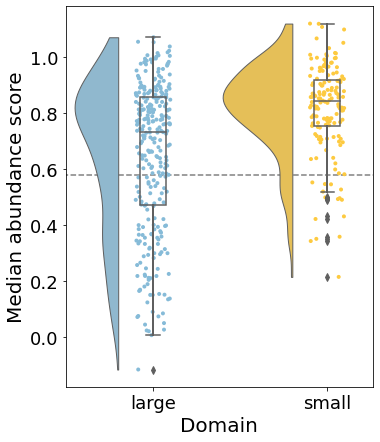

In [122]:
dx = "domain"; dy = "Med_score_abundance"; ort = "v"; pal = "Set2"; sigma = .3
f, ax = plt.subplots(figsize=(5.5,7))

ax1 = pt.RainCloud(x=dx, y=dy, data = gck_domains_no_hinge, palette = ['#86BBD8','#FDCA40'],
               bw = sigma,width_viol = 0.8, ax = ax, orient = ort,point_size=4)

ax1.set_ylabel('Median abundance score')
ax1.set_xlabel('Domain')

ax1.plot([-1,3],[0.58,0.58],c='gray',ls='--',zorder=-1,label='threshold')

plt.savefig('output-manuscript/med_abundance_domains.pdf',dpi=600, facecolor='w', bbox_inches='tight')


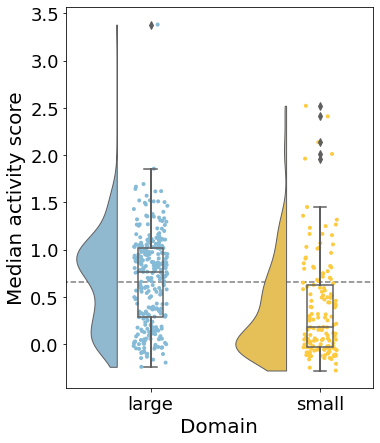

In [123]:
dx = "domain"; dy = "Med_score_activity"; ort = "v"; pal = "Set2"; sigma = .3
f, ax = plt.subplots(figsize=(5.5,7))

ax1 = pt.RainCloud(x=dx, y=dy, data = gck_domains_no_hinge_act, palette = ['#86BBD8','#FDCA40'],
               bw = sigma,width_viol = 0.6, ax = ax, orient = ort,point_size=4)

ax1.set_ylabel('Median activity score')
ax1.set_xlabel('Domain')

ax1.plot([-1,3],[0.66,0.66],c='gray',ls='--',zorder=-1,label='threshold')

#plt.savefig('output-manuscript/med_activity_domains.png',dpi=600, facecolor='w', bbox_inches='tight')


## Analysis of solvent-exposure and buriedness

### Load structural features data

struc_df_1v4t_loop contains data for 1v4t with Modeller loop (data is average over five models). We add data for missing loop residues (defined in missing_loop_resi) to struc_df_1v4t, which contains structural features calculated directly from the 1v4t crystal structure, which is missing the loop residues.

In [124]:
# load DataFrames with structural features 
struc_df_1v4s = pd.read_excel("data/additional_file_2.xlsx",sheet_name="WCN_1V4S")
struc_df_1v4t = pd.read_excel("data/additional_file_2.xlsx",sheet_name="WCN_1V4T")
struc_df_1v4t_loop = pd.read_excel("data/additional_file_2.xlsx",sheet_name="WCN_avg_model")

# extract information for loop residues from struc_df_1v4t_loop
missing_loop_resi = [157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
struc_df_loop = struc_df_1v4t_loop.iloc[np.isin(struc_df_1v4t_loop.residue_number.values,missing_loop_resi)]

# remove loop residues, which has only nan, from struc_df_1v4t
struc_df_1v4t_remove_loop = struc_df_1v4t.iloc[~np.isin(struc_df_1v4t.residue_number.values,missing_loop_resi)]

# add loop information to struc_df_1v4t 
struc_df_1v4t = pd.concat([struc_df_1v4t_remove_loop,struc_df_loop]).sort_values(by=['residue_number']).reset_index().drop(columns=['index'])

# rename columns
struc_df_1v4s = struc_df_1v4s.rename(columns={'rASA':'rASA_1v4s'})
struc_df_1v4t = struc_df_1v4t.rename(columns={'rASA':'rASA_1v4t'})

### Buried/exposed residues per domain

In [125]:
# calculate number of exposed and buried residues in the two domains with rASA cutoff of 0.2

In [126]:
rasa_cut = 0.2

In [127]:
print("Closed conformation, large domain")
struc_df_1v4s_ld = struc_df_1v4s.iloc[np.isin(struc_df_1v4s.residue_number.values, domain_resi_dict["large_domain"])]

buried = len(struc_df_1v4s_ld[struc_df_1v4s_ld.rASA_1v4s <= 0.2])
exposed = len(struc_df_1v4s_ld[struc_df_1v4s_ld.rASA_1v4s > 0.2])

print("buried:",len(struc_df_1v4s_ld[struc_df_1v4s_ld.rASA_1v4s <= 0.2]))
print("exposed:",len(struc_df_1v4s_ld[struc_df_1v4s_ld.rASA_1v4s > 0.2]))
print("ratio:",exposed/buried)

Closed conformation, large domain
buried: 173
exposed: 114
ratio: 0.6589595375722543


In [128]:
print("Closed conformation, small domain")
struc_df_1v4s_ld = struc_df_1v4s.iloc[np.isin(struc_df_1v4s.residue_number.values, domain_resi_dict["small_domain"])]

buried = len(struc_df_1v4s_ld[struc_df_1v4s_ld.rASA_1v4s <= 0.2])
exposed = len(struc_df_1v4s_ld[struc_df_1v4s_ld.rASA_1v4s > 0.2])

print("buried:",len(struc_df_1v4s_ld[struc_df_1v4s_ld.rASA_1v4s <= 0.2]))
print("exposed:",len(struc_df_1v4s_ld[struc_df_1v4s_ld.rASA_1v4s > 0.2]))
print("ratio:",exposed/buried)

Closed conformation, small domain
buried: 87
exposed: 63
ratio: 0.7241379310344828


In [129]:
print("Superopen conformation, large domain")
struc_df_1v4t_ld = struc_df_1v4t.iloc[np.isin(struc_df_1v4t.residue_number.values, domain_resi_dict["large_domain"])]

buried = len(struc_df_1v4t_ld[struc_df_1v4t_ld.rASA_1v4t <= 0.2])
exposed = len(struc_df_1v4t_ld[struc_df_1v4t_ld.rASA_1v4t > 0.2])

print("buried:",len(struc_df_1v4t_ld[struc_df_1v4t_ld.rASA_1v4t <= 0.2]))
print("exposed:",len(struc_df_1v4t_ld[struc_df_1v4t_ld.rASA_1v4t > 0.2]))
print("ratio:",exposed/buried)

Superopen conformation, large domain
buried: 165
exposed: 122
ratio: 0.7393939393939394


In [130]:
print("Superopen conformation, small domain")
struc_df_1v4t_ld = struc_df_1v4t.iloc[np.isin(struc_df_1v4t.residue_number.values, domain_resi_dict["small_domain"])]

buried = len(struc_df_1v4t_ld[struc_df_1v4t_ld.rASA_1v4t <= 0.2])
exposed = len(struc_df_1v4t_ld[struc_df_1v4t_ld.rASA_1v4t > 0.2])

print("buried:",len(struc_df_1v4t_ld[struc_df_1v4t_ld.rASA_1v4t <= 0.2]))
print("exposed:",len(struc_df_1v4t_ld[struc_df_1v4t_ld.rASA_1v4t > 0.2]))
print("ratio:",exposed/buried)

Superopen conformation, small domain
buried: 49
exposed: 101
ratio: 2.061224489795918


In [131]:
# calculations for closed structure

In [132]:
# residues with low abundance in large domain, divided by buried residues in large domain
(0.33*(173+114)) / 173

0.547456647398844

In [133]:
# residues with low abundance in small domain, divided by buried residues in small domain
(0.1*(87+63)) / 87

0.1724137931034483

In [134]:
# calculations for superopen structure

In [135]:
# residues with low abundance in large domain, divided by buried residues in large domain
(0.33*(165+122)) / 165

0.5740000000000001

In [136]:
# residues with low abundance in small domain, divided by buried residues in small domain
(0.1*(49+101)) / 49

0.30612244897959184

### Plot rASA

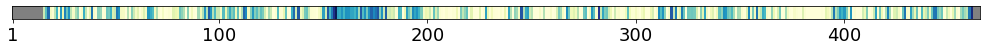

In [137]:
# plot rASA per residue position in superopen conformation
plt.rcParams['font.size'] = '16'
fig, (ax1) = plt.subplots(1,1,figsize=(14,1))
ax1.imshow(struc_df_1v4t.rASA_1v4t.values.reshape(1,-1),cmap="YlGnBu",aspect='auto',vmin=0,vmax=1,interpolation='nearest')
ax1.set_facecolor('grey')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(struc_df_1v4t.rASA_1v4t.values)+.5-1);
ax1.set_xticks(ticks=[1-1,100-1,200-1,300-1,400-1]);
ax1.set_xticklabels([1,100,200,300,400]);
plt.tight_layout()

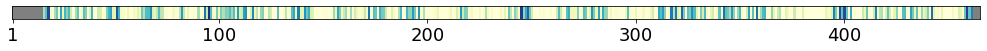

In [138]:
# plot rASA per residue position in closed conformation
plt.rcParams['font.size'] = '16'
fig, (ax1) = plt.subplots(1,1,figsize=(14,1))
ax1.imshow(struc_df_1v4s.rASA_1v4s.values.reshape(1,-1),cmap="YlGnBu",aspect='auto',vmin=0,vmax=1,interpolation='nearest')
ax1.set_facecolor('grey')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(struc_df_1v4t.rASA_1v4t.values)+.5-1);
ax1.set_xticks(ticks=[1-1,100-1,200-1,300-1,400-1]);
ax1.set_xticklabels([1,100,200,300,400]);
plt.tight_layout()

## Load data ddG data

In [139]:
ddg_df_dict = {}

In [140]:
# read 1v4s data
ddg_df_dict["1v4s"] = pd.read_excel("data/additional_file_2.xlsx",sheet_name="ddG_1V4S")

# add residue numbers to 1v4s data
ddg_df_dict["1v4s"]["resi"] = get_resi_arr(ddg_df_dict["1v4s"])

# remove nonnative residues
ddg_df_dict['1v4s'] = ddg_df_dict['1v4s'][ddg_df_dict['1v4s']['resi'] > 15]

# update ddG column to restrict values to be in -1 to 7 range
ddg_df_dict["1v4s"]["ddG_1v4s"] = ddg_map_to_range(ddg_df_dict["1v4s"]["ddG_1v4s"])

# remove data for synonymous variants
aa_var = get_aa_var_arr(ddg_df_dict['1v4s'])
missense_arr = np.where(np.array(aa_var != '='))[0]
ddg_df_dict["1v4s"] = ddg_df_dict["1v4s"].iloc[missense_arr]

In [141]:
# read 1v4t data
ddg_df_dict["1v4t"] = pd.read_excel("data/additional_file_2.xlsx",sheet_name="ddG_1V4T")

# add residue numbers to 1v4t data
ddg_df_dict["1v4t"]["resi"] = get_resi_arr(ddg_df_dict["1v4t"])

# remove nonnative residues
ddg_df_dict['1v4t'] = ddg_df_dict['1v4t'][ddg_df_dict['1v4t']['resi'] > 15]

# update ddG column to restrict values to be in -1 to 7 range
ddg_df_dict["1v4t"]["ddG_1v4t"] = ddg_map_to_range(ddg_df_dict["1v4t"]["ddG_1v4t"])

# remove data for synonymous variants
aa_var = get_aa_var_arr(ddg_df_dict['1v4t'])
missense_arr = np.where(np.array(aa_var != '='))[0]
ddg_df_dict["1v4t"] = ddg_df_dict["1v4t"].iloc[missense_arr]

In [142]:
# read 1v4s with glc data
ddg_df_dict["1v4s_glc"] = pd.read_excel("data/additional_file_2.xlsx",sheet_name="ddG_1V4S_GLC")

# slide and rename columns
ddg_df_dict["1v4s_glc"] = ddg_df_dict["1v4s_glc"][["variant","mean_ddG","resi"]]
ddg_df_dict["1v4s_glc"] = ddg_df_dict["1v4s_glc"].rename(columns={"mean_ddG":"ddG_1v4s_glc"}) 

# update ddG column to restrict values to be in -1 to 7 range
ddg_df_dict["1v4s_glc"]["ddG_1v4s_glc"] = ddg_map_to_range(ddg_df_dict["1v4s_glc"]["ddG_1v4s_glc"])

# remove data for synonymous variants
aa_var = get_aa_var_arr(ddg_df_dict['1v4s_glc'])
missense_arr = np.where(np.array(aa_var != '='))[0]
ddg_df_dict["1v4s_glc"] = ddg_df_dict["1v4s_glc"].iloc[missense_arr]

In [143]:
# read 1v4t with modelled loop (average of 5 models based on 1v4t + MODELLER loop)
ddg_df_dict["1v4t_avg_model"] = pd.read_excel("data/additional_file_2.xlsx",sheet_name="ddG_all")

# slide and rename columns
ddg_df_dict["1v4t_avg_model"] = ddg_df_dict["1v4t_avg_model"][["variant","mean_ddG_MODELLER_1v4t","resi"]]
ddg_df_dict["1v4t_avg_model"] = ddg_df_dict["1v4t_avg_model"].rename(columns={"mean_ddG_MODELLER_1v4t":"ddG_1v4t_avg_model"})

# update ddG column to restrict values to be in -1 to 7 range
ddg_df_dict["1v4t_avg_model"]["ddG_1v4t_avg_model"] = ddg_map_to_range(ddg_df_dict["1v4t_avg_model"]["ddG_1v4t_avg_model"])

# remove data for synonymous variants
aa_var = get_aa_var_arr(ddg_df_dict['1v4t_avg_model'])
missense_arr = np.where(np.array(aa_var != '='))[0]
ddg_df_dict["1v4t_avg_model"] = ddg_df_dict["1v4t_avg_model"].iloc[missense_arr]

In [144]:
# create dataset based on 1v4t with avg values for loop

# identify residues missing from 1v4t crystal corresponding to loop
resi_1v4t = np.unique(ddg_df_dict['1v4t']['resi'])
resi_all = np.arange(np.min(resi_1v4t),np.max(resi_1v4t)+1)
missing_loop_resi = resi_all[~np.isin(resi_all, resi_1v4t)]

# get ddg scores from average modeller scores for missing loop residues
avg_ddg_loop_df = ddg_df_dict["1v4t_avg_model"].iloc[np.isin(ddg_df_dict["1v4t_avg_model"]['resi'], missing_loop_resi)]

# concat
rename_avg_ddg_loop_df = avg_ddg_loop_df.rename(columns={"ddG_1v4t_avg_model":"ddG_1v4t_avg_model_comb"})
rename_ddg_1v4t_df = ddg_df_dict["1v4t"].rename(columns={"ddG_1v4t":"ddG_1v4t_avg_model_comb"})

ddg_df_dict["1v4t_avg_model_comb"] = pd.concat([rename_ddg_1v4t_df,rename_avg_ddg_loop_df]).reset_index().sort_values(by=["resi","variant"]).drop(columns=["index"])

## Compare ddG values for structures with and without glucose bound

In [145]:
# identify residues in glucose binding site based on PDB structure

shift_by = 15 # when you use original pdb file, shift residue numbers
dist_cut = 4 # cutoff distance, how close should glc and residue be for residue to be in binding site

# load pdb
pdb=md.load("data/1v4s_GLC_MRK.pdb")

# select atoms 
prot_atom_idx = pdb.top.select("protein")
prot_pdb = pdb.atom_slice(prot_atom_idx)
glc_atom_idx = pdb.top.select("not protein and resname GLC")
glc_pdb = pdb.atom_slice(glc_atom_idx)

# make arrays with residue indices (starting from 0)
prot_resi_idx = np.array([int(str(resi)[3:]) for resi in list(prot_pdb.top.residues)]) - 1 - shift_by
glc_resi_idx = np.array([prot_resi_idx[-1] + 1])

# define pairs of residues between protein and ligands
glc_resi_pair_arr = np.stack((prot_resi_idx,np.repeat(glc_resi_idx,len(prot_resi_idx))),axis=1)

# calculate distances
glc_dists, glc_pairs = md.compute_contacts(
    pdb,contacts=glc_resi_pair_arr,scheme="closest-heavy",ignore_nonprotein=False,periodic=False
)

# selecting residues involved in binding (based on looking at the structure with different cutoff distances)
# add 16 to go from idx to residue number in pdb structure
glc_bind_res_arr = glc_pairs[:,0][(glc_dists[0] * 10) < dist_cut] + 16 

# print glucose binding site residues selected above
print(list(glc_bind_res_arr))

# filter ddg dataframes to only contain data for ligand binding residues
glc_bind_res_dict = {}
for model in ['1v4s_glc','1v4s']:
    glc_res_df = ddg_df_dict[model].iloc[np.isin(ddg_df_dict[model].resi.values, glc_bind_res_arr)]
    glc_bind_res_dict[model] = glc_res_df

[151, 152, 153, 168, 169, 204, 205, 225, 229, 230, 231, 256, 287, 290]


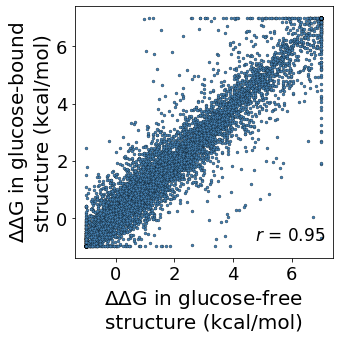

In [146]:
# plot correlation for all variants in entire structure

# check variants are the same
assert np.all(ddg_df_dict['1v4s'].variant.values == ddg_df_dict['1v4s_glc'].variant.values)

# plot
plot_ddg_corr(ddg_df_dict['1v4s']['ddG_1v4s'].values,ddg_df_dict['1v4s_glc']['ddG_1v4s_glc'].values,ms=3)

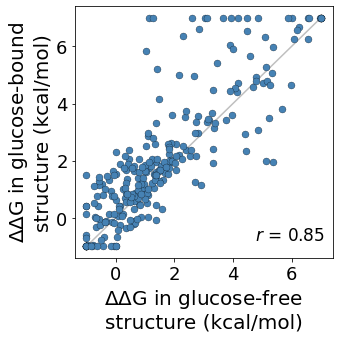

In [147]:
# plot correlation for all variants in binding site residues

# check variants are the same
assert np.all(glc_bind_res_dict['1v4s'].variant.values == glc_bind_res_dict['1v4s_glc'].variant.values)

# plot
plot_ddg_corr(glc_bind_res_dict['1v4s']['ddG_1v4s'].values,glc_bind_res_dict['1v4s_glc']['ddG_1v4s_glc'].values,ms=7)

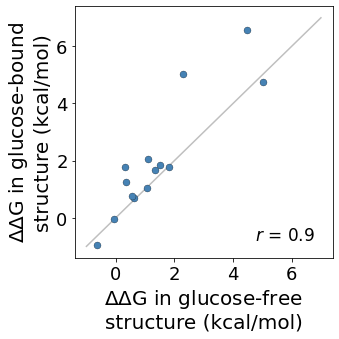

In [148]:
# correlation with median per residue for binding site residues

# calculate medians
glc_bind_res_1v4s_median = glc_bind_res_dict['1v4s'].groupby('resi').median().reset_index()
glc_bind_res_1v4s_glc_median = glc_bind_res_dict['1v4s_glc'].groupby('resi').median().reset_index()

# check residues are the same
assert np.all(glc_bind_res_1v4s_median.resi.values == glc_bind_res_1v4s_glc_median.resi.values)

# plot
plot_ddg_corr(glc_bind_res_1v4s_median['ddG_1v4s'],glc_bind_res_1v4s_glc_median['ddG_1v4s_glc'],ms=7)

In [149]:
# find variants with a ddG at least 2 kcal/mol larger when glucose is bound
glc_destab_var = glc_bind_res_dict['1v4s_glc'][glc_bind_res_dict['1v4s_glc']['ddG_1v4s_glc'].values > glc_bind_res_dict['1v4s']['ddG_1v4s'].values + 2]
glc_destab_var = glc_destab_var.variant.values

In [150]:
# add variants to dataframe
glc_destab_var_df = pd.DataFrame()
glc_destab_var_df["variant"] = glc_destab_var
glc_destab_var_df["ddG_1v4s"] = glc_bind_res_dict['1v4s'][np.isin(glc_bind_res_dict['1v4s'].variant.values,glc_destab_var)]["ddG_1v4s"].values
glc_destab_var_df["ddG_1v4s_glc"] = glc_bind_res_dict['1v4s_glc'][np.isin(glc_bind_res_dict['1v4s_glc'].variant.values,glc_destab_var)]["ddG_1v4s_glc"].values

In [151]:
glc_destab_var_df

,variant,ddG_1v4s,ddG_1v4s_glc
0,G229D,3.897471,6.048966
1,G229F,4.473908,6.531609
2,G229H,2.830460,6.607356
3,G229L,3.034713,7.000000
4,G229M,4.865747,7.000000
5,G229W,3.102644,7.000000
6,G229Y,4.175287,7.000000
7,C230Q,2.687126,4.960000
8,N231F,1.121494,7.000000
9,N231H,2.286552,6.366667


## Plot activity and abundance data against Rosetta ddGs and GEMME scores on domain basis

In [152]:
# read abundance data and filter out synonymous and nonsense data
abundance_data = pd.read_csv('data/abundance.csv')
abundance_data = abundance_data[(abundance_data['aa_var'] != '=') & (abundance_data['aa_var'] != 'Ter')]
abundance_data.head()

,variant,abundance_score,abundance_score_se,df,residue_number,aa_ref,aa_var
1,L2A,0.846497,0.696283,8,2.0,L,A
2,L2C,1.013018,0.054077,4,2.0,L,C
3,L2D,1.133868,0.108695,4,2.0,L,D
4,L2E,1.020231,0.172689,4,2.0,L,E
5,L2F,1.018625,0.118101,4,2.0,L,F


In [153]:
# read activity data and filter out synonymous and nonsense data
activity_data = pd.read_csv('data/activity.csv')
activity_data = activity_data[(activity_data['aa_var'] != '=') & (activity_data['aa_var'] != 'Ter')]
activity_data.head()

,variant,activity_score,activity_score_se,df,residue_number,aa_ref,aa_var
1,L2A,0.473709,0.240087,4,2.0,L,A
2,L2C,0.760261,0.042343,2,2.0,L,C
3,L2D,1.174395,0.089257,2,2.0,L,D
4,L2E,0.704607,0.182289,2,2.0,L,E
5,L2F,1.008850,0.063567,2,2.0,L,F


In [154]:
# read gemme data
gemme_data = pd.read_excel("data/additional_file_2.xlsx",sheet_name="GEMME_scores",comment="#")
gemme_data = gemme_data.rename(columns={"mutation":"variant","GEMME score":"gemme_score"})

In [155]:
# create DataFrame with all experimental and computational data
gck_all_df = pd.DataFrame(columns=['variant'])

In [156]:
# find variants occuring in either activity or abundance data
common_var_arr = np.unique(np.concatenate([abundance_data.variant.values,activity_data.variant.values]))
gck_all_df['variant'] = common_var_arr

# make arrays with variant amino acids and residue numbers
aa_ref_arr = [var[0] for var in common_var_arr]
aa_var_arr = [var[-1] for var in common_var_arr]
resi_arr = [int(var[1:-1]) for var in common_var_arr]

# add to DataFrame and sort by variant name
gck_all_df['resi'] = resi_arr
gck_all_df['aa_ref'] = aa_ref_arr
gck_all_df['aa_var'] = aa_var_arr

gck_all_df = gck_all_df.sort_values(by=['resi', 'aa_var'])
gck_all_df = gck_all_df.reset_index().drop(columns=['index'])

In [157]:
# add all data
gck_all_df = gck_all_df.merge(activity_data[['variant','activity_score']], how='left', on='variant')
gck_all_df = gck_all_df.merge(abundance_data[['variant','abundance_score']], how='left', on='variant')
gck_all_df = gck_all_df.merge(gemme_data[['variant','gemme_score']],how='left',on='variant')
gck_all_df = gck_all_df.merge(ddg_df_dict['1v4s'][['variant','ddG_1v4s']], how='left', on='variant')
gck_all_df = gck_all_df.merge(ddg_df_dict['1v4t_avg_model_comb'][['variant','ddG_1v4t_avg_model_comb']], how='left', on='variant')

In [158]:
gck_all_df.head()

,variant,resi,aa_ref,aa_var,activity_score,abundance_score,gemme_score,ddG_1v4s,ddG_1v4t_avg_model_comb
0,L2A,2,L,A,0.473709,0.846497,-0.100864,NaN,NaN
1,L2C,2,L,C,0.760261,1.013018,-0.100864,NaN,NaN
2,L2D,2,L,D,1.174395,1.133868,-0.100864,NaN,NaN
3,L2E,2,L,E,0.704607,1.020231,-0.100864,NaN,NaN
4,L2F,2,L,F,1.008850,1.018625,-0.100864,NaN,NaN


In [159]:
# create df with median values per residue
gck_all_df_median = gck_all_df.groupby("resi").median()
gck_all_df_median = gck_all_df_median.reset_index()

In [160]:
gck_all_df_median.head()

,resi,activity_score,abundance_score,gemme_score,ddG_1v4s,ddG_1v4t_avg_model_comb
0,2,0.952201,0.911430,-0.100864,NaN,NaN
1,3,0.973981,0.501029,0.000000,NaN,NaN
2,4,1.072142,0.549991,0.000000,NaN,NaN
3,5,0.867536,1.022325,0.000000,NaN,NaN
4,6,0.659049,0.870981,0.000000,NaN,NaN


In [161]:
# create dictionaries holding dataframes with data only for residues and variants
# in a given domain, i.e. either in the large or small domain

# extract array with residue numbers from DataFrame
gck_all_df_resi_arr = gck_all_df.resi.values
gck_all_df_median_resi_arr = gck_all_df_median.resi.values

# make dict for storing sliced DataFrames
domain_df_dict = {}
domain_df_median_dict = {}
    
# loop over domains
for domain in ['large_domain','small_domain']:

    # slice df to only include data for residues in specificed conf and domain
    domain_df = gck_all_df.iloc[np.isin(gck_all_df_resi_arr, domain_resi_dict[domain])]
    domain_df_median = gck_all_df_median.iloc[np.isin(gck_all_df_median_resi_arr, domain_resi_dict[domain])]

    # add sliced DataFrame to dict
    domain_df_dict[domain] = domain_df
    domain_df_median_dict[domain] = domain_df_median

In [162]:
# plot

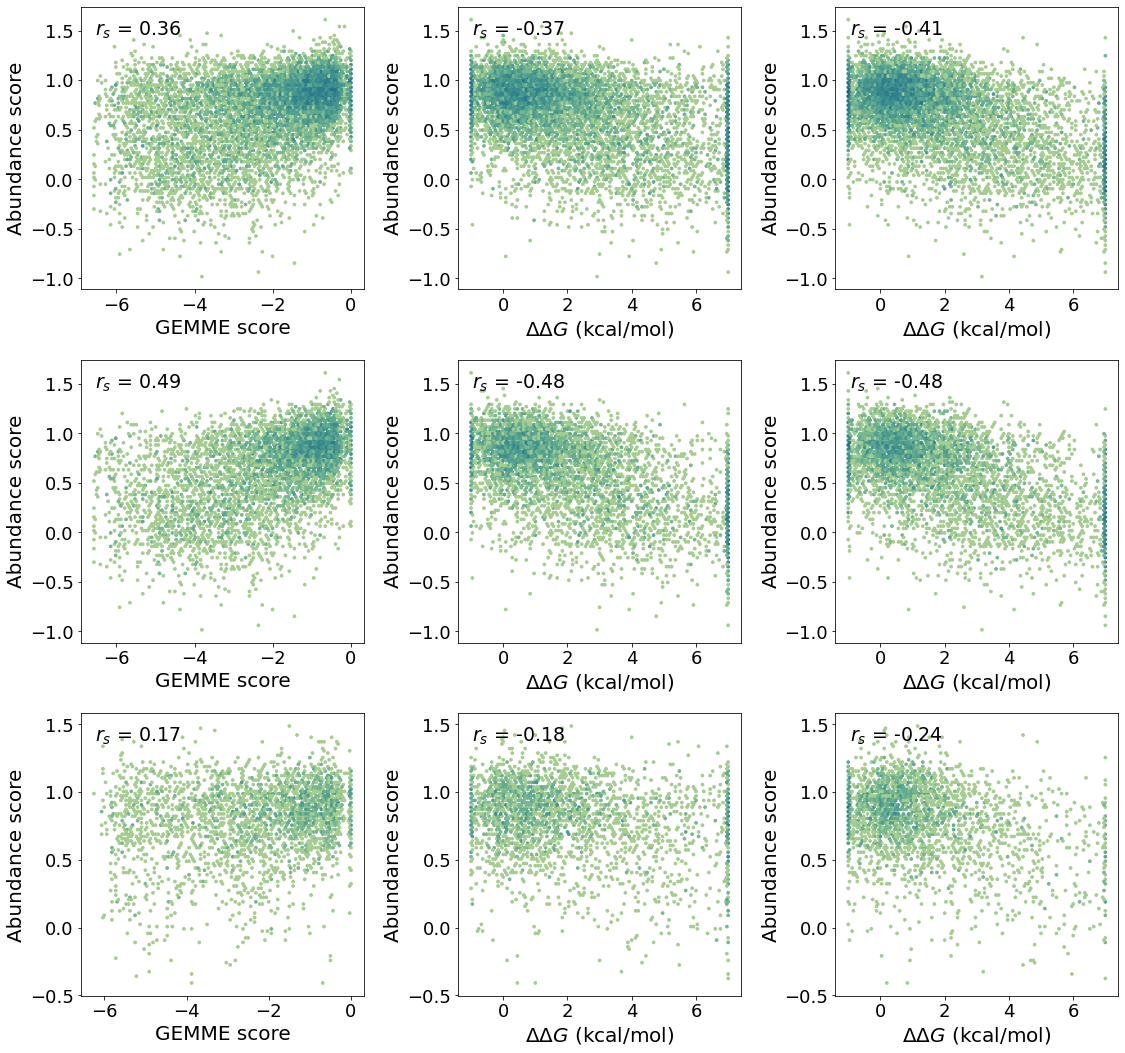

In [163]:
scatter_per_domain(gck_all_df, domain_df_dict, 'abundance_score', 'variants')

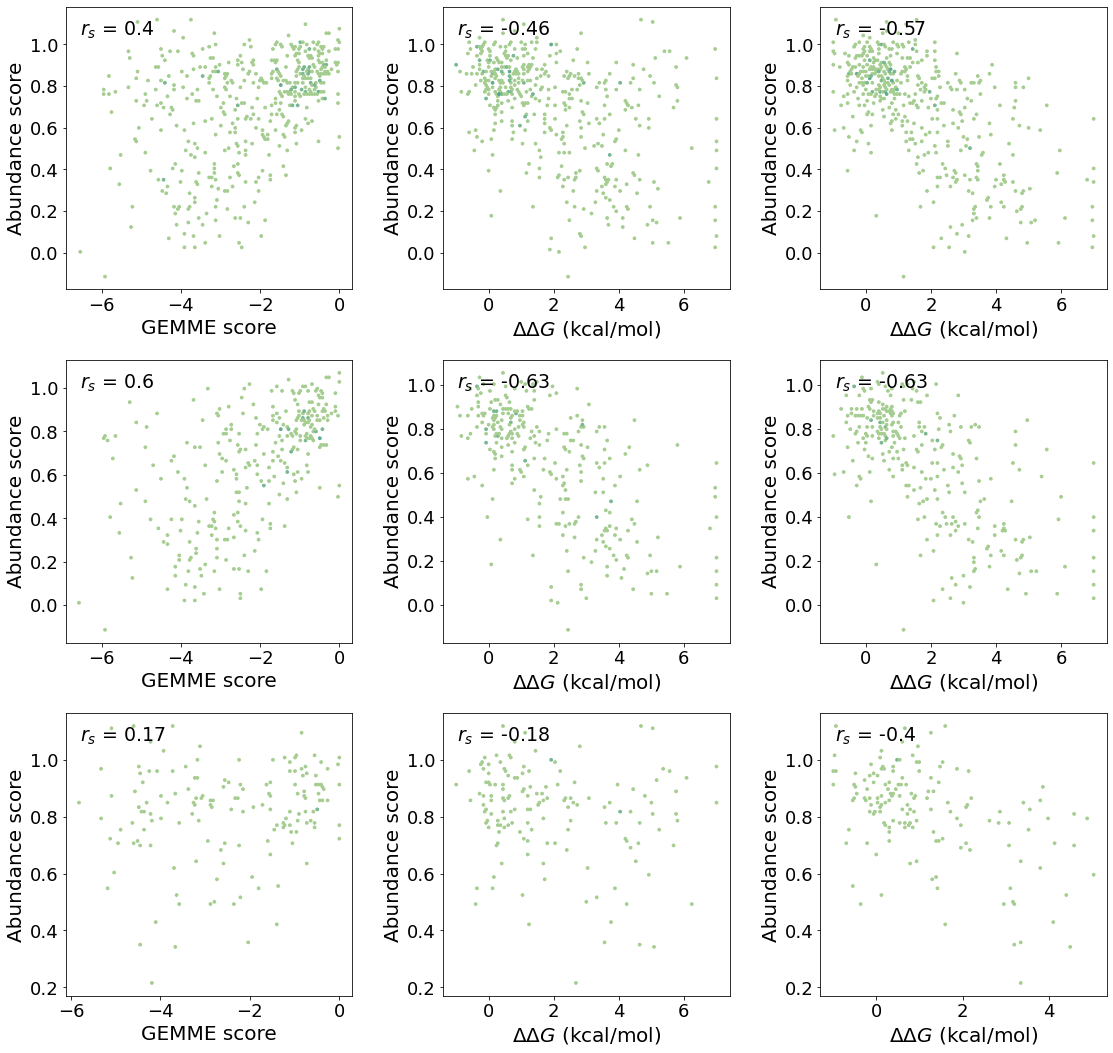

In [164]:
scatter_per_domain(gck_all_df_median, domain_df_median_dict, 'abundance_score', 'residues')

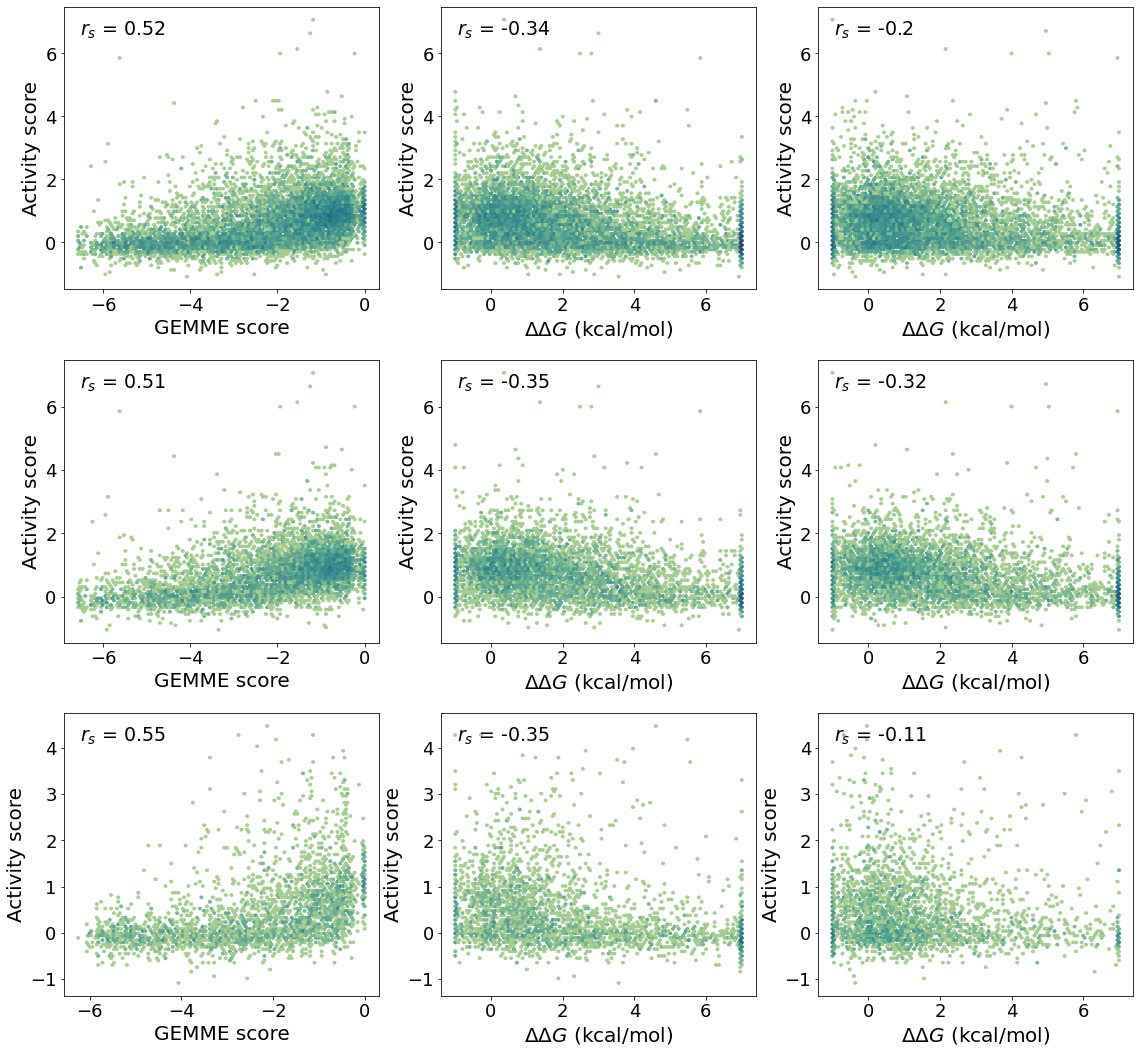

In [165]:
scatter_per_domain(gck_all_df, domain_df_dict, 'activity_score', 'variants')

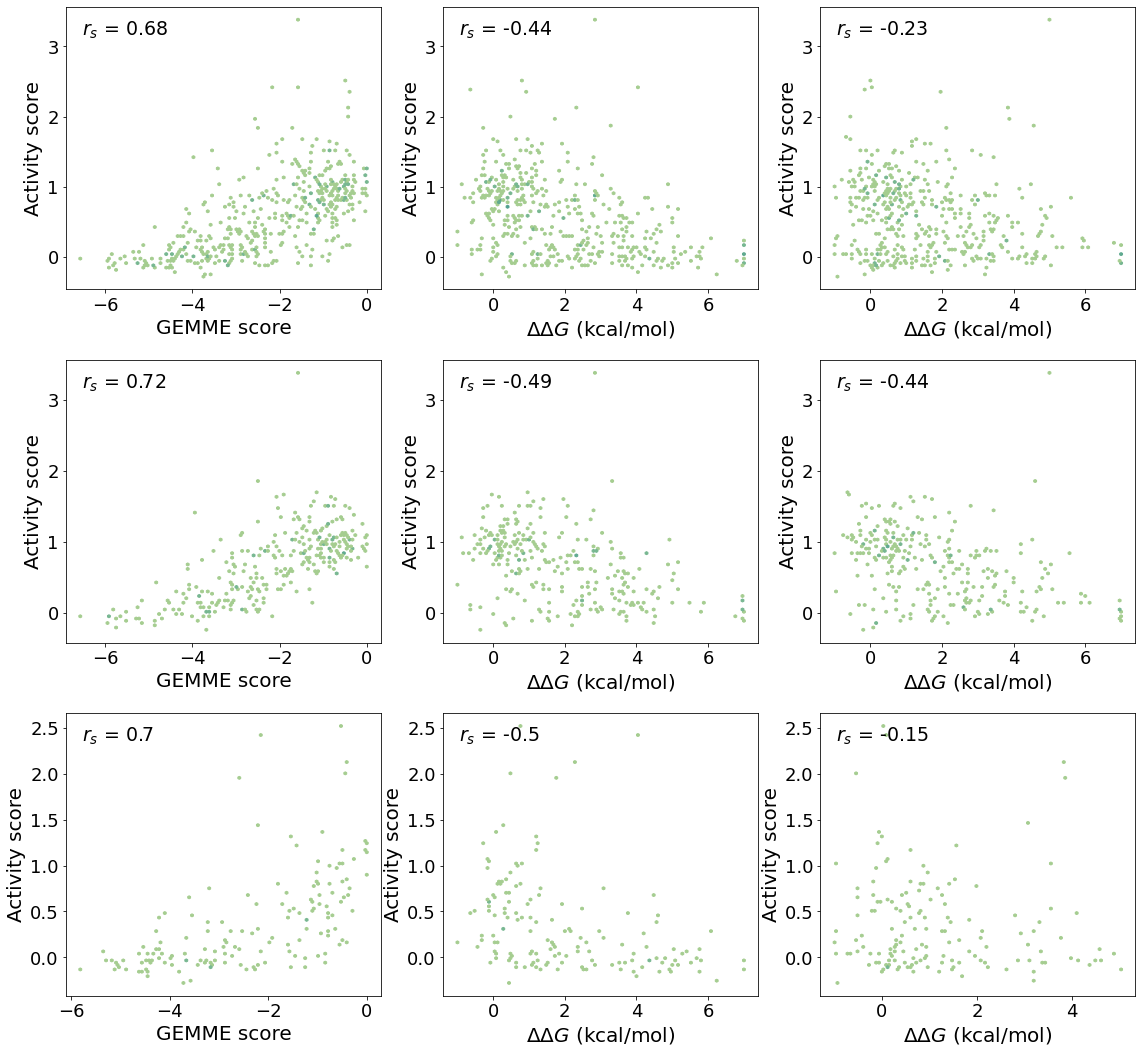

In [166]:
scatter_per_domain(gck_all_df_median, domain_df_median_dict, 'activity_score', 'residues')

# Gaussian fitting to obtain threshold

## Scores

over threshold variants: 4729  ( 56.324440209623624 %)


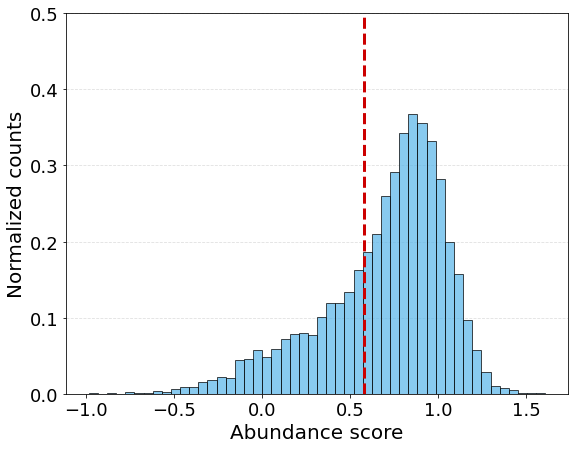

In [167]:
score_histogram(GCK_scores,50,'#56b4e9','Abundance score', 'True',0.77)

y_size=[0,0.5]
vert_line = np.array( [0.58 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=3)
plt.ylim(0,0.5)

plt.savefig('output-manuscript/abundance-histo-MAVE.pdf')

## Threshold definition: Tri-gaussian model fit

In [168]:
y,x,_=hist(GCK_scores[~np.isnan(GCK_scores)],100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(0.0,0.5,50,0.5,0.2,100,1,0.25,300)
params,cov=curve_fit(bimodal,x,y,p0=expected)
sigma=sqrt(diag(cov))
plt.close()

In [169]:
gaus_fit_params=pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
print(gaus_fit_params)

            params      sigma
mu1       0.182627   0.149222
sigma1    0.293631   0.071938
A1       60.400763  14.457416
mu2       0.524424   0.039585
sigma2    0.161371   0.048669
A2       72.380363  40.080045
mu3       0.888614   0.011288
sigma3    0.172819   0.006092
A3      331.612711   9.935169


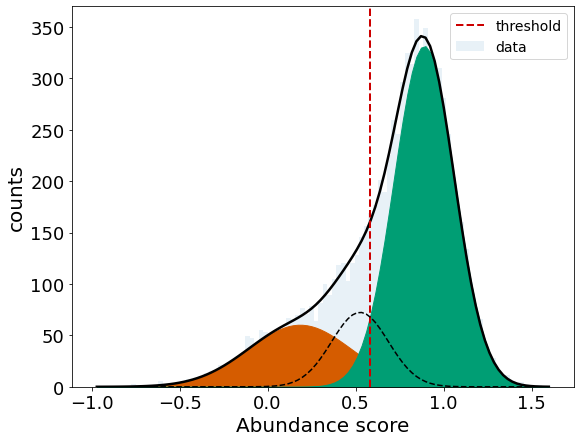

In [170]:
hist(GCK_scores[~np.isnan(GCK_scores)],100,alpha=.1,label='data')

plot(x,gauss(x,gaus_fit_params.iloc[3,0],gaus_fit_params.iloc[4,0],gaus_fit_params.iloc[5,0]),color='black',zorder=3,ls='--')
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[0,0],gaus_fit_params.iloc[1,0],gaus_fit_params.iloc[2,0]),color='#D55C00',zorder=2)
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[6,0],gaus_fit_params.iloc[7,0],gaus_fit_params.iloc[8,0]),color='#009E74',zorder=2)
plot(x,bimodal(x,*params),color='black',lw=2.5)
y_size=[0,370]
vert_line = np.array( [0.58 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='threshold',color='#cc0000',lw=2)
plt.xlabel("Abundance score")
plt.ylabel("counts")
plt.ylim(0,370)
legend()
#plt.savefig("output-manuscript/gaussian_threshold.pdf")